In [0]:
# Read IoT CSV directly from S3
iot_df = (
    spark.read.csv(
        "s3://hqpsusu-ml-data-bucket/raw/iot/metropt.csv",
        header=True,
        inferSchema=True
    )
)

# Preview data
iot_df.show(5)
iot_df.printSchema()


+-------------------+-------------------+-----+-----+-------------------+------------------+-----------------+-----------+-----------------+----+----------+------+---+---+---------------+---------+---------------+--------+-------+--------+----------+
|          timestamp|                TP2|  TP3|   H1|        DV_pressure|        Reservoirs|  Oil_temperature|  Flowmeter|    Motor_current|COMP|DV_eletric|Towers|MPG|LPS|Pressure_switch|Oil_level|Caudal_impulses| gpsLong| gpsLat|gpsSpeed|gpsQuality|
+-------------------+-------------------+-----+-----+-------------------+------------------+-----------------+-----------+-----------------+----+----------+------+---+---+---------------+---------+---------------+--------+-------+--------+----------+
|2022-01-01 06:00:00|-0.0120000000000004|9.758| 9.76|-0.0279999999999986|1.5760000000000003|            63.35|  19.049625|            3.955|   1|         0|     1|  1|  0|              0|        0|              0|-8.65934|41.2124|       0|        

In [0]:
from pyspark.sql.functions import col, to_timestamp, round as spark_round

# Convert timestamp, drop rows with missing GPS, round coordinates
iot_clean = (
    iot_df
    .withColumn("timestamp", to_timestamp("timestamp"))   # ensure proper timestamp type
    .dropna(subset=["gpsLat", "gpsLong"])                 # remove missing GPS rows
    .withColumn("lat_rounded", spark_round(col("gpsLat"), 2))
    .withColumn("lon_rounded", spark_round(col("gpsLong"), 2))
)

# Show cleaned sample
iot_clean.show(5)
iot_clean.printSchema()


+-------------------+-------------------+-----+-----+-------------------+------------------+-----------------+-----------+-----------------+----+----------+------+---+---+---------------+---------+---------------+--------+-------+--------+----------+-----------+-----------+
|          timestamp|                TP2|  TP3|   H1|        DV_pressure|        Reservoirs|  Oil_temperature|  Flowmeter|    Motor_current|COMP|DV_eletric|Towers|MPG|LPS|Pressure_switch|Oil_level|Caudal_impulses| gpsLong| gpsLat|gpsSpeed|gpsQuality|lat_rounded|lon_rounded|
+-------------------+-------------------+-----+-----+-------------------+------------------+-----------------+-----------+-----------------+----+----------+------+---+---+---------------+---------+---------------+--------+-------+--------+----------+-----------+-----------+
|2022-01-01 06:00:00|-0.0120000000000004|9.758| 9.76|-0.0279999999999986|1.5760000000000003|            63.35|  19.049625|            3.955|   1|         0|     1|  1|  0|    

In [0]:
from pyspark.sql.functions import window, hour, date_trunc

# Add hour bucket for grouping
iot_features = (
    iot_clean
    .withColumn("timestamp_hour", date_trunc("hour", col("timestamp")))  # truncate to hour
)

# Show sample
iot_features.select("timestamp", "timestamp_hour", "lat_rounded", "lon_rounded").show(5)


+-------------------+-------------------+-----------+-----------+
|          timestamp|     timestamp_hour|lat_rounded|lon_rounded|
+-------------------+-------------------+-----------+-----------+
|2022-01-01 06:00:00|2022-01-01 06:00:00|      41.21|      -8.66|
|2022-01-01 06:00:01|2022-01-01 06:00:00|      41.21|      -8.66|
|2022-01-01 06:00:02|2022-01-01 06:00:00|      41.21|      -8.66|
|2022-01-01 06:00:03|2022-01-01 06:00:00|      41.21|      -8.66|
|2022-01-01 06:00:04|2022-01-01 06:00:00|      41.21|      -8.66|
+-------------------+-------------------+-----------+-----------+
only showing top 5 rows


In [0]:
from pyspark.sql.functions import avg, stddev, min, max

# Aggregate by hour and location
iot_hourly = (
    iot_features
    .groupBy("timestamp_hour", "lat_rounded", "lon_rounded")
    .agg(
        avg("TP2").alias("TP2_avg"),
        stddev("TP2").alias("TP2_std"),
        avg("TP3").alias("TP3_avg"),
        avg("H1").alias("H1_avg"),
        avg("DV_pressure").alias("DV_pressure_avg"),
        avg("Oil_temperature").alias("Oil_temp_avg"),
        avg("Motor_current").alias("Motor_current_avg"),
        max("Motor_current").alias("Motor_current_max"),
        min("Motor_current").alias("Motor_current_min")
    )
)

iot_hourly.show(5)


+-------------------+-----------+-----------+--------------------+--------------------+-----------------+-----------------+--------------------+------------------+--------------------+------------------+------------------+
|     timestamp_hour|lat_rounded|lon_rounded|             TP2_avg|             TP2_std|          TP3_avg|           H1_avg|     DV_pressure_avg|      Oil_temp_avg|   Motor_current_avg| Motor_current_max| Motor_current_min|
+-------------------+-----------+-----------+--------------------+--------------------+-----------------+-----------------+--------------------+------------------+--------------------+------------------+------------------+
|2022-01-01 14:00:00|      41.17|      -8.58|-0.00937055837563...|0.001328550765159262|9.527390862944166|9.530507614213198|-0.02724873096446...| 69.91624365482231|  3.8595558375634504|             3.975|              3.73|
|2022-01-01 19:00:00|      41.15|      -8.59|-0.00741573033707...|0.001213643919285...|8.470831460674155|8.4

In [0]:
output_path = "s3://hqpsusu-ml-data-bucket/processed/iot_hourly_features"

iot_hourly.write.mode("overwrite").parquet(output_path)

print(f"✅ Features saved to {output_path}")


✅ Features saved to s3://hqpsusu-ml-data-bucket/processed/iot_hourly_features


In [0]:
features = spark.read.parquet("s3://hqpsusu-ml-data-bucket/processed/iot_hourly_features")

# Inspect schema + sample
features.printSchema()
features.show(5)

# Quick summary stats
features.describe(["TP2_avg", "TP3_avg", "Oil_temp_avg", "Motor_current_avg"]).show()

# Built-in Databricks visualization
display(features.select("timestamp_hour", "Motor_current_avg"))


root
 |-- timestamp_hour: timestamp (nullable = true)
 |-- lat_rounded: double (nullable = true)
 |-- lon_rounded: double (nullable = true)
 |-- TP2_avg: double (nullable = true)
 |-- TP2_std: double (nullable = true)
 |-- TP3_avg: double (nullable = true)
 |-- H1_avg: double (nullable = true)
 |-- DV_pressure_avg: double (nullable = true)
 |-- Oil_temp_avg: double (nullable = true)
 |-- Motor_current_avg: double (nullable = true)
 |-- Motor_current_max: double (nullable = true)
 |-- Motor_current_min: double (nullable = true)

+-------------------+-----------+-----------+--------------------+--------------------+-----------------+------------------+--------------------+-----------------+--------------------+------------------+------------------+
|     timestamp_hour|lat_rounded|lon_rounded|             TP2_avg|             TP2_std|          TP3_avg|            H1_avg|     DV_pressure_avg|     Oil_temp_avg|   Motor_current_avg| Motor_current_max| Motor_current_min|
+-------------------

timestamp_hour Motor_current_avg 2022-01-01T08:00:00Z 0.007500000000000241 2022-01-01T09:00:00Z 3.493659420289854 2022-01-02T00:00:00Z 3.9050362318840603 2022-01-02T17:00:00Z 3.798047619047617 2022-01-03T06:00:00Z 1.963153153153153 2022-01-03T23:00:00Z 3.870489130434783 2022-01-03T23:00:00Z 2.5756976744186244 2022-01-04T10:00:00Z 3.7836548223350266 2022-01-04T14:00:00Z 4.310033333333333 2022-01-07T00:00:00Z 0.00124999999999975 2022-01-07T18:00:00Z 3.8463430851063802 2022-01-07T23:00:00Z 1.7241379310341378E-4 2022-01-09T08:00:00Z 3.756875 2022-01-09T09:00:00Z 3.8290948275862084 2022-01-10T20:00:00Z 1.193513194444482 2022-01-01T18:00:00Z 1.3666991525423726 2022-01-01T21:00:00Z 0.42538435374149286 2022-01-02T10:00:00Z 0.3667194092827 2022-01-03T06:00:00Z 0.3727332361515994 2022-01-03T13:00:00Z 3.757857142857142 2022-01-04T06:00:00Z 1.444458525345588 2022-01-04T11:00:00Z 3.0931748071979444 2022-01-04T12:00:00Z 0.16813609467455626 2022-01-05T00:00:00Z 0.6055822981366439 2022-01-05T01:00:00Z 0.0046428571428562175 2022-01-06T14:00:00Z 0.003396226415093662 2022-01-07T15:00:00Z 2.3550187969924816 2022-01-08T23:00:00Z 2.9096565315315326 2022-01-10T12:00:00Z 4.808685897435898 2022-01-10T14:00:00Z 0.002922535211267024 2022-01-10T16:00:00Z 3.774999999999999 2022-01-11T20:00:00Z 1.8151513888888877 2022-01-01T08:00:00Z 3.8667000000000007 2022-01-01T19:00:00Z 3.798813131313133 2022-01-01T23:00:00Z 0.00715701219512198 2022-01-02T07:00:00Z 3.0234861111111218 2022-01-02T14:00:00Z 0.001216216216215973 2022-01-02T16:00:00Z 3.7959935897435892 2022-01-02T16:00:00Z 4.033333333333333 2022-01-03T09:00:00Z 4.392686567164181 2022-01-03T12:00:00Z 0.0028571428571422855 2022-01-03T14:00:00Z 3.6033933333333317 2022-01-04T00:00:00Z 3.831796875 2022-01-04T15:00:00Z 3.7476388888888885 2022-01-07T16:00:00Z 2.687409502262441 2022-01-07T18:00:00Z 3.1733908045976995 2022-01-09T11:00:00Z 2.9919724770642224 2022-01-09T11:00:00Z 0.0024999999999995 2022-01-12T15:00:00Z 3.7585000000000006 2022-01-03T06:00:00Z 5.914999999999999 2022-01-03T12:00:00Z 3.756491228070177 2022-01-04T06:00:00Z 4.573906249999999 2022-01-04T10:00:00Z 2.3683783783783765 2022-01-04T23:00:00Z 3.827282608695651 2022-01-05T11:00:00Z 9.135802469133984E-4 2022-01-06T21:00:00Z 0.0 2022-01-06T23:00:00Z 1.1014767779390513 2022-01-07T16:00:00Z 0.004999999999998999 2022-01-07T23:00:00Z 3.4050179211462747E-4 2022-01-09T14:00:00Z 0.0045833333333324166 2022-01-10T13:00:00Z 3.7707142857142855 2022-01-10T14:00:00Z 1.853284883720929 2022-01-11T17:00:00Z 1.8163993055554997 2022-01-01T09:00:00Z 3.861839080459769 2022-01-01T11:00:00Z 2.5546732026143792 2022-01-02T00:00:00Z 0.006874999999999899 2022-01-02T10:00:00Z 0.001720588235293775 2022-01-02T13:00:00Z 4.7752808988754523E-4 2022-01-03T20:00:00Z 3.7878642384105974 2022-01-04T13:00:00Z -2.683615819208503E-4 2022-01-05T02:00:00Z 5.7225 2022-01-06T21:00:00Z 3.802342857142856 2022-01-06T21:00:00Z -2.3148148148143517E-4 2022-01-07T00:00:00Z 0.0020588235294113546 2022-01-01T18:00:00Z 0.003189655172413158 2022-01-02T07:00:00Z 3.788928571428572 2022-01-03T06:00:00Z 3.1852877697841855 2022-01-03T08:00:00Z 4.614787535410768 2022-01-03T09:00:00Z 4.555735294117646 2022-01-04T08:00:00Z 2.0637980769231135 2022-01-04T10:00:00Z 0.0024999999999995 2022-01-05T10:00:00Z 3.7921428571428577 2022-01-07T01:00:00Z 0.002290268456375383 2022-01-07T09:00:00Z 3.5882665094339607 2022-01-07T15:00:00Z 0.004890109890108916 2022-01-07T20:00:00Z 0.002749999999999451 2022-01-08T23:00:00Z 3.844600591715976 2022-01-10T16:00:00Z -5.263157894735789E-4 2022-01-12T16:00:00Z -0.001021739130434579 2022-01-02T01:00:00Z 0.004821428571427612 2022-01-02T09:00:00Z 3.8063223140495857 2022-01-02T22:00:00Z 3.8779347826086954 2022-01-03T15:00:00Z 4.530119047619048 2022-01-03T19:00:00Z 3.7587909836065587 2022-01-03T21:00:00Z 3.7806854838709683 2022-01-05T09:00:00Z 2.064802325581423 2022-01-06T23:00:00Z 3.7797656250000014 2022-01-09T00:00:00Z 0.0024999999999994996 2022-01-12T16:00:00Z 1.207859168241966 2022-01-01T13:0

In [0]:
for col in ["COMP", "LPS", "MPG", "Pressure_switch", "DV_eletric", "Towers", "Oil_level"]:
    iot_raw.groupBy(col).count().orderBy(col).show()


+----+-------+
|COMP|  count|
+----+-------+
|   0|1401723|
|   1|9371865|
+----+-------+

+---+--------+
|LPS|   count|
+---+--------+
|  0|10705915|
|  1|   67673|
+---+--------+

+---+-------+
|MPG|  count|
+---+-------+
|  0|1401729|
|  1|9371859|
+---+-------+

+---------------+--------+
|Pressure_switch|   count|
+---------------+--------+
|              0|10773588|
+---------------+--------+

+----------+-------+
|DV_eletric|  count|
+----------+-------+
|         0|9371797|
|         1|1401791|
+----------+-------+

+------+--------+
|Towers|   count|
+------+--------+
|     0|  702757|
|     1|10070831|
+------+--------+

+---------+--------+
|Oil_level|   count|
+---------+--------+
|        0|10773585|
|        1|       3|
+---------+--------+



In [0]:
from pyspark.sql import functions as F

# Add failure column based on strict rule
iot_labeled = (
    iot_raw.withColumn(
        "failure",
        F.when(
            (F.col("COMP") == 0) &
            (F.col("MPG") == 0) &
            (F.col("LPS") == 0),
            1
        ).otherwise(0)
    )
)

# Check a sample
iot_labeled.select("timestamp", "COMP", "MPG", "LPS", "failure").show(10)

# Count how many failure vs non-failure rows
iot_labeled.groupBy("failure").count().show()


+-------------------+----+---+---+-------+
|          timestamp|COMP|MPG|LPS|failure|
+-------------------+----+---+---+-------+
|2022-01-01 06:00:00|   1|  1|  0|      0|
|2022-01-01 06:00:01|   1|  1|  0|      0|
|2022-01-01 06:00:02|   1|  1|  0|      0|
|2022-01-01 06:00:03|   1|  1|  0|      0|
|2022-01-01 06:00:04|   1|  1|  0|      0|
|2022-01-01 06:00:05|   1|  1|  0|      0|
|2022-01-01 06:00:06|   1|  1|  0|      0|
|2022-01-01 06:00:07|   1|  1|  0|      0|
|2022-01-01 06:00:08|   1|  1|  0|      0|
|2022-01-01 06:00:09|   1|  1|  0|      0|
+-------------------+----+---+---+-------+
only showing top 10 rows
+-------+-------+
|failure|  count|
+-------+-------+
|      1|1334048|
|      0|9439540|
+-------+-------+



In [0]:
from pyspark.sql import functions as F

# 1. Define failure flag in your raw IoT data
iot_failures = (
    iot_raw
    .withColumn(
        "failure",
        F.when((F.col("COMP") == 0) & (F.col("MPG") == 0) & (F.col("LPS") == 0), 1).otherwise(0)
    )
    .withColumn("timestamp_hour", F.date_trunc("hour", F.col("timestamp")))
    .withColumn("lat_rounded", F.round(F.col("gpsLat"), 2))
    .withColumn("lon_rounded", F.round(F.col("gpsLong"), 2))
)

# 2. Aggregate to hourly failures
failures_hourly = (
    iot_failures
    .groupBy("timestamp_hour", "lat_rounded", "lon_rounded")
    .agg(F.max("failure").alias("failure"))
)

# 3. Load your hourly features
features = spark.read.parquet("s3://hqpsusu-ml-data-bucket/processed/iot_hourly_features")

# 4. Join features with failures
features_with_failures = (
    features.join(
        failures_hourly,
        on=["timestamp_hour", "lat_rounded", "lon_rounded"],
        how="left"
    )
    .fillna({"failure": 0})
)

# 5. Quick check
features_with_failures.groupBy("failure").count().show()
features_with_failures.show(5)


+-------+-----+
|failure|count|
+-------+-----+
|      1| 8969|
|      0|12986|
+-------+-----+

+-------------------+-----------+-----------+--------------------+--------------------+-----------------+-----------------+--------------------+------------------+--------------------+------------------+------------------+-------+
|     timestamp_hour|lat_rounded|lon_rounded|             TP2_avg|             TP2_std|          TP3_avg|           H1_avg|     DV_pressure_avg|      Oil_temp_avg|   Motor_current_avg| Motor_current_max| Motor_current_min|failure|
+-------------------+-----------+-----------+--------------------+--------------------+-----------------+-----------------+--------------------+------------------+--------------------+------------------+------------------+-------+
|2022-01-01 14:00:00|      41.17|      -8.58|-0.00937055837563...|0.001328550765159262|9.527390862944166|9.530507614213198|-0.02724873096446...| 69.91624365482231|  3.8595558375634504|             3.975|       

In [0]:
from pyspark.sql import functions as F

# Load features again
features = spark.read.parquet("s3://hqpsusu-ml-data-bucket/processed/iot_hourly_features")

# Load failure labels again
iot_raw = (
    spark.read.csv(
        "s3://hqpsusu-ml-data-bucket/raw/iot/metropt.csv",
        header=True,
        inferSchema=True
    )
)

# Create stricter failure label at row-level
iot_fail = (
    iot_raw.withColumn("failure", F.when((F.col("COMP")==0) & (F.col("MPG")==0) & (F.col("LPS")==0), 1).otherwise(0))
    .withColumn("timestamp_hour", F.date_trunc("hour", F.col("timestamp")))
    .groupBy("timestamp_hour")
    .agg(F.max("failure").alias("failure"))   # 1 if any failure in that hour
)

# Join onto features
features_with_failure = features.join(iot_fail, on="timestamp_hour", how="left")

features_with_failure.select("timestamp_hour", "Motor_current_avg", "Oil_temp_avg", "DV_pressure_avg", "failure").show(5)


+-------------------+--------------------+------------------+--------------------+-------+
|     timestamp_hour|   Motor_current_avg|      Oil_temp_avg|     DV_pressure_avg|failure|
+-------------------+--------------------+------------------+--------------------+-------+
|2022-01-02 00:00:00|  3.9050362318840603| 63.12391304347826|-0.02875362318840...|      1|
|2022-01-06 14:00:00|0.002865853658536014| 67.51890243902439|-0.02724390243902352|      1|
|2022-01-06 12:00:00|0.005135135135134203|59.153378378378385|-0.02924324324324321|      1|
|2022-01-03 13:00:00|  3.6313854489164124| 72.71865325077398|0.001894736842105...|      1|
|2022-01-02 17:00:00|   3.798047619047617|  70.5480952380952|-0.02681904761904...|      1|
+-------------------+--------------------+------------------+--------------------+-------+
only showing top 5 rows


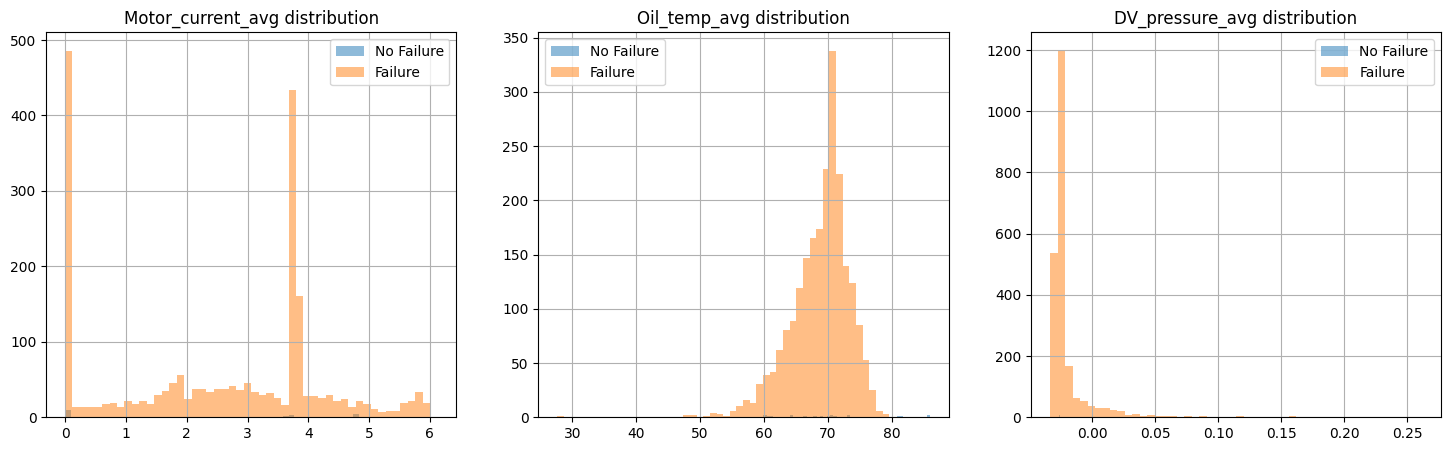

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Pandas (sample if too large)
pdf = features_with_failure.select(
    "Motor_current_avg", "Oil_temp_avg", "DV_pressure_avg", "failure"
).sample(fraction=0.1, seed=42).toPandas()

fig, axes = plt.subplots(1, 3, figsize=(18,5))

for ax, col in zip(axes, ["Motor_current_avg", "Oil_temp_avg", "DV_pressure_avg"]):
    pdf[pdf["failure"]==0][col].hist(ax=ax, bins=50, alpha=0.5, label="No Failure")
    pdf[pdf["failure"]==1][col].hist(ax=ax, bins=50, alpha=0.5, label="Failure")
    ax.set_title(f"{col} distribution")
    ax.legend()

plt.show()


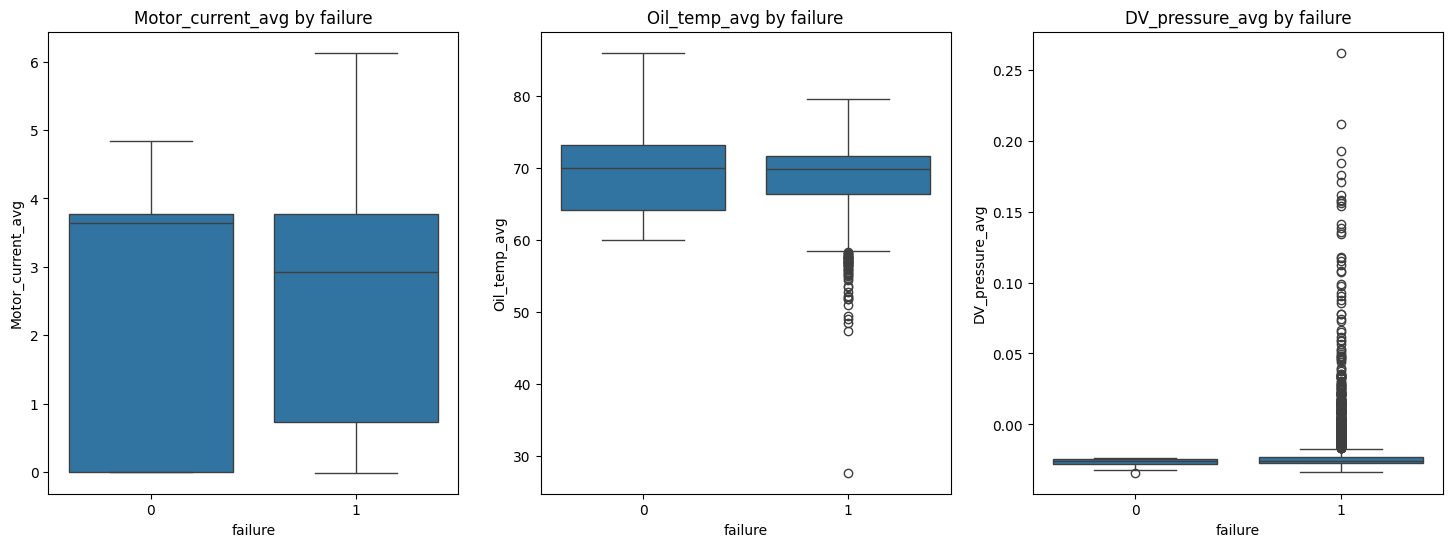

In [0]:
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(18,6))
for ax, col in zip(axes, ["Motor_current_avg", "Oil_temp_avg", "DV_pressure_avg"]):
    sns.boxplot(x="failure", y=col, data=pdf, ax=ax)
    ax.set_title(f"{col} by failure")

plt.show()


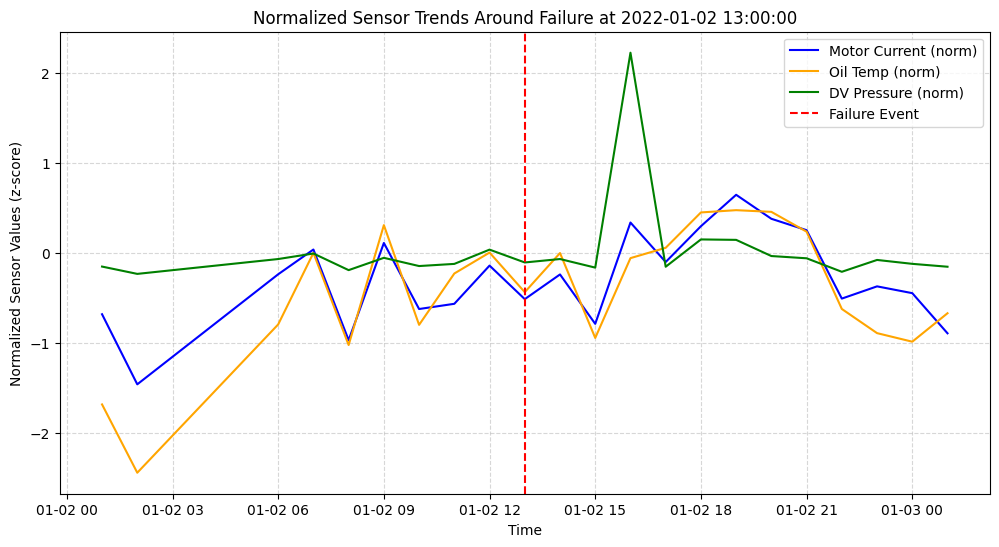

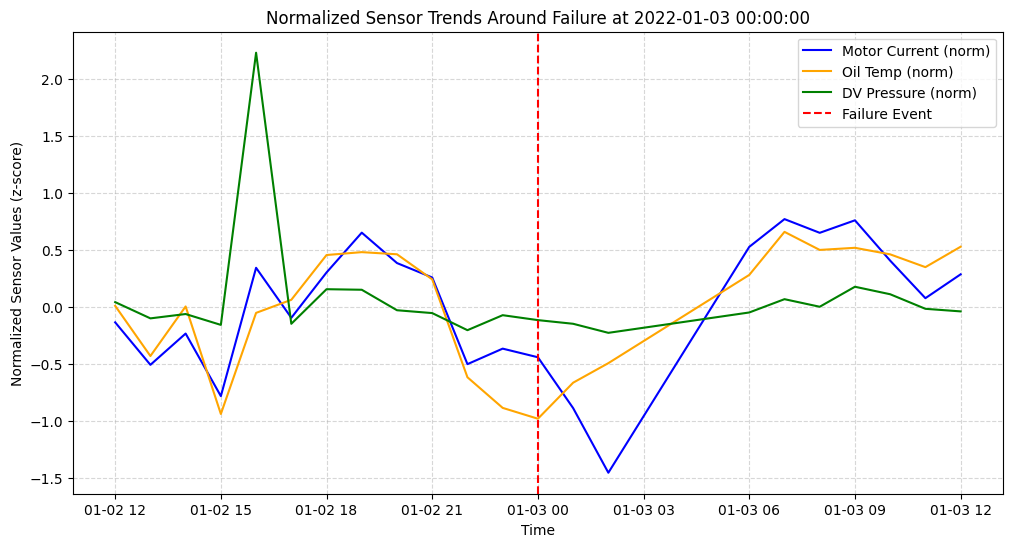

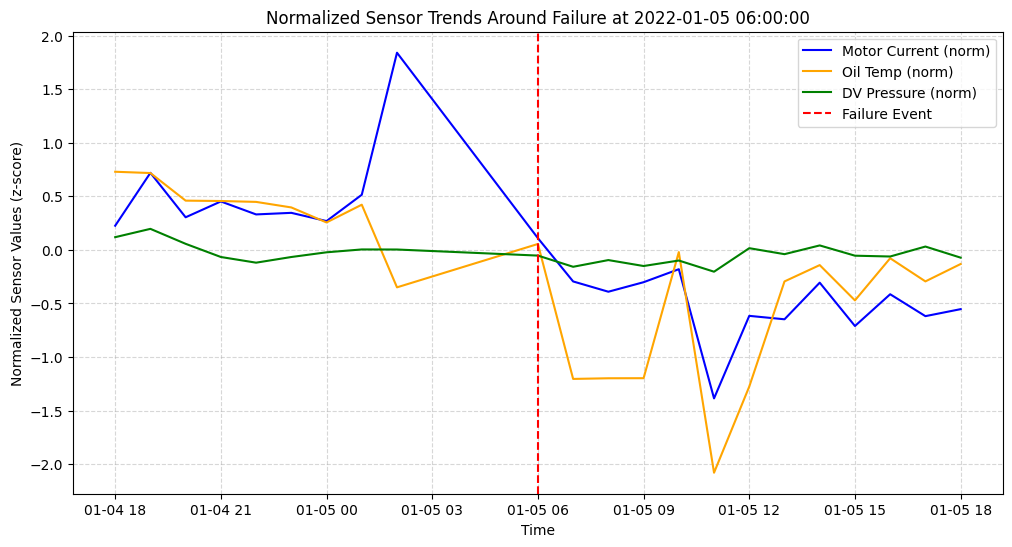

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# Pick a few failure hours
failure_times = (
    features_with_failure
    .filter(features_with_failure.failure == 1)
    .select("timestamp_hour")
    .distinct()
    .limit(3)  # sample 3 failures
    .toPandas()["timestamp_hour"]
)

# Convert to pandas
pdf = features_with_failure.toPandas()

# Normalize signals for comparability
for col in ["Motor_current_avg", "Oil_temp_avg", "DV_pressure_avg"]:
    pdf[col + "_norm"] = (pdf[col] - pdf[col].mean()) / pdf[col].std()

# Plot around each failure
for ft in failure_times:
    window = pdf[
        (pdf["timestamp_hour"] >= ft - pd.Timedelta(hours=12)) &
        (pdf["timestamp_hour"] <= ft + pd.Timedelta(hours=12))
    ]
    
    # Aggregate to avoid noise (mean per timestamp)
    window_grouped = window.groupby("timestamp_hour")[["Motor_current_avg_norm", 
                                                      "Oil_temp_avg_norm", 
                                                      "DV_pressure_avg_norm"]].mean().reset_index()
    
    plt.figure(figsize=(12,6))
    plt.plot(window_grouped["timestamp_hour"], window_grouped["Motor_current_avg_norm"], 
             label="Motor Current (norm)", color="blue")
    plt.plot(window_grouped["timestamp_hour"], window_grouped["Oil_temp_avg_norm"], 
             label="Oil Temp (norm)", color="orange")
    plt.plot(window_grouped["timestamp_hour"], window_grouped["DV_pressure_avg_norm"], 
             label="DV Pressure (norm)", color="green")
    
    # Failure marker
    plt.axvline(ft, color="red", linestyle="--", label="Failure Event")
    plt.title(f"Normalized Sensor Trends Around Failure at {ft}")
    plt.xlabel("Time")
    plt.ylabel("Normalized Sensor Values (z-score)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


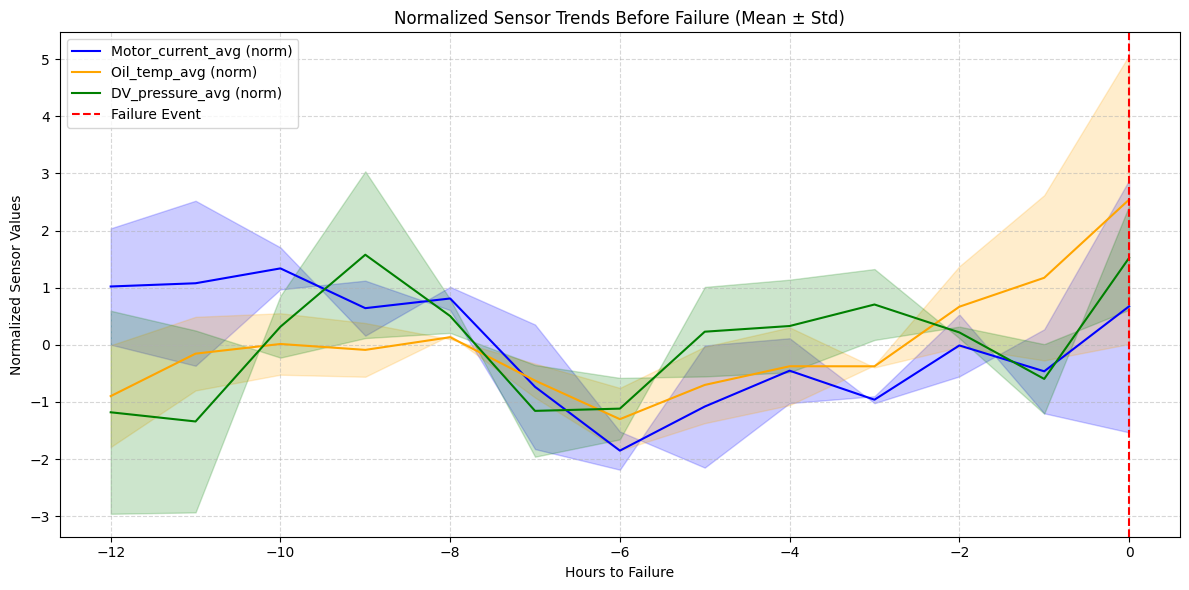

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to Pandas for plotting
pdf = features_with_failure.toPandas()
pdf['timestamp_hour'] = pd.to_datetime(pdf['timestamp_hour'])

# Filter failure timestamps
failure_times = pdf[pdf['failure'] == 1]['timestamp_hour']

# Collect pre-failure windows
records = []
window = 12  # hours before failure

for ft in failure_times:
    subset = pdf[(pdf['timestamp_hour'] >= ft - pd.Timedelta(hours=window)) &
                 (pdf['timestamp_hour'] <= ft)]
    subset = subset.copy()
    subset['hours_to_failure'] = (subset['timestamp_hour'] - ft).dt.total_seconds() / 3600
    records.append(subset)

# Combine all failures
aligned = pd.concat(records)

# Aggregate mean and std
agg = aligned.groupby('hours_to_failure')[['Motor_current_avg','Oil_temp_avg','DV_pressure_avg']] \
             .agg(['mean','std'])

# Normalize (z-score by mean across time)
norm = (agg - agg.mean()) / agg.std()

# Plot normalized trends with shaded std bands
plt.figure(figsize=(12,6))

for sensor, color in zip(['Motor_current_avg','Oil_temp_avg','DV_pressure_avg'],
                         ['blue','orange','green']):
    mean = norm[sensor]['mean']
    std = norm[sensor]['std']
    plt.plot(mean.index, mean.values, label=f"{sensor} (norm)", color=color)
    plt.fill_between(mean.index, mean-std, mean+std, color=color, alpha=0.2)

plt.axvline(0, color="red", linestyle="--", label="Failure Event")
plt.title("Normalized Sensor Trends Before Failure (Mean ± Std)")
plt.xlabel("Hours to Failure")
plt.ylabel("Normalized Sensor Values")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [0]:
from pyspark.sql import functions as F, Window

# Define window ordered by time
w = Window.orderBy("timestamp_hour")

# Failure condition
cond = (F.col("COMP") == 0) & (F.col("MPG") == 0) & (F.col("LPS") == 0)

# Transition into failure (1 only at the first failure hour)
features_with_failure = features_with_failure.withColumn(
    "failure",
    F.when(
        cond & (~F.lag(cond.cast("int"), 1, 0).over(w).cast("boolean")),
        1
    ).otherwise(0)
)


/databricks/spark/python/pyspark/sql/connect/expressions.py:1061: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(
{"ts": "2025-08-27 05:33:05.691", "level": "ERROR", "logger": "DataFrameQueryContextLogger", "msg": "[UNRESOLVED_COLUMN.WITH_SUGGESTION] A column, variable, or function parameter with name `COMP` cannot be resolved. Did you mean one of the following? [`H1_avg`, `TP2_avg`, `TP2_std`, `TP3_avg`, `failure`]. SQLSTATE: 42703;\n'Project [timestamp_hour#6474, lat_rounded#6475, lon_rounded#6476, TP2_avg#6477, TP2_std#6478, TP3_avg#6479, H1_avg#6480, DV_pressure_avg#6481, Oil_temp_avg#6482, Motor_current_avg#6483, Motor_current_max#6484, Motor_current_min#6485, CASE WHEN 'and('and('and('`==`('COMP, 0), '`==`('MPG, 0)), '`==`('LPS, 0)), 'not(cast('lag(cast('and('and('`==`('COMP, 0), '`==`('MPG, 0)), '`==`('LPS, 0)) as int), 1, 0) windowspecdefinition

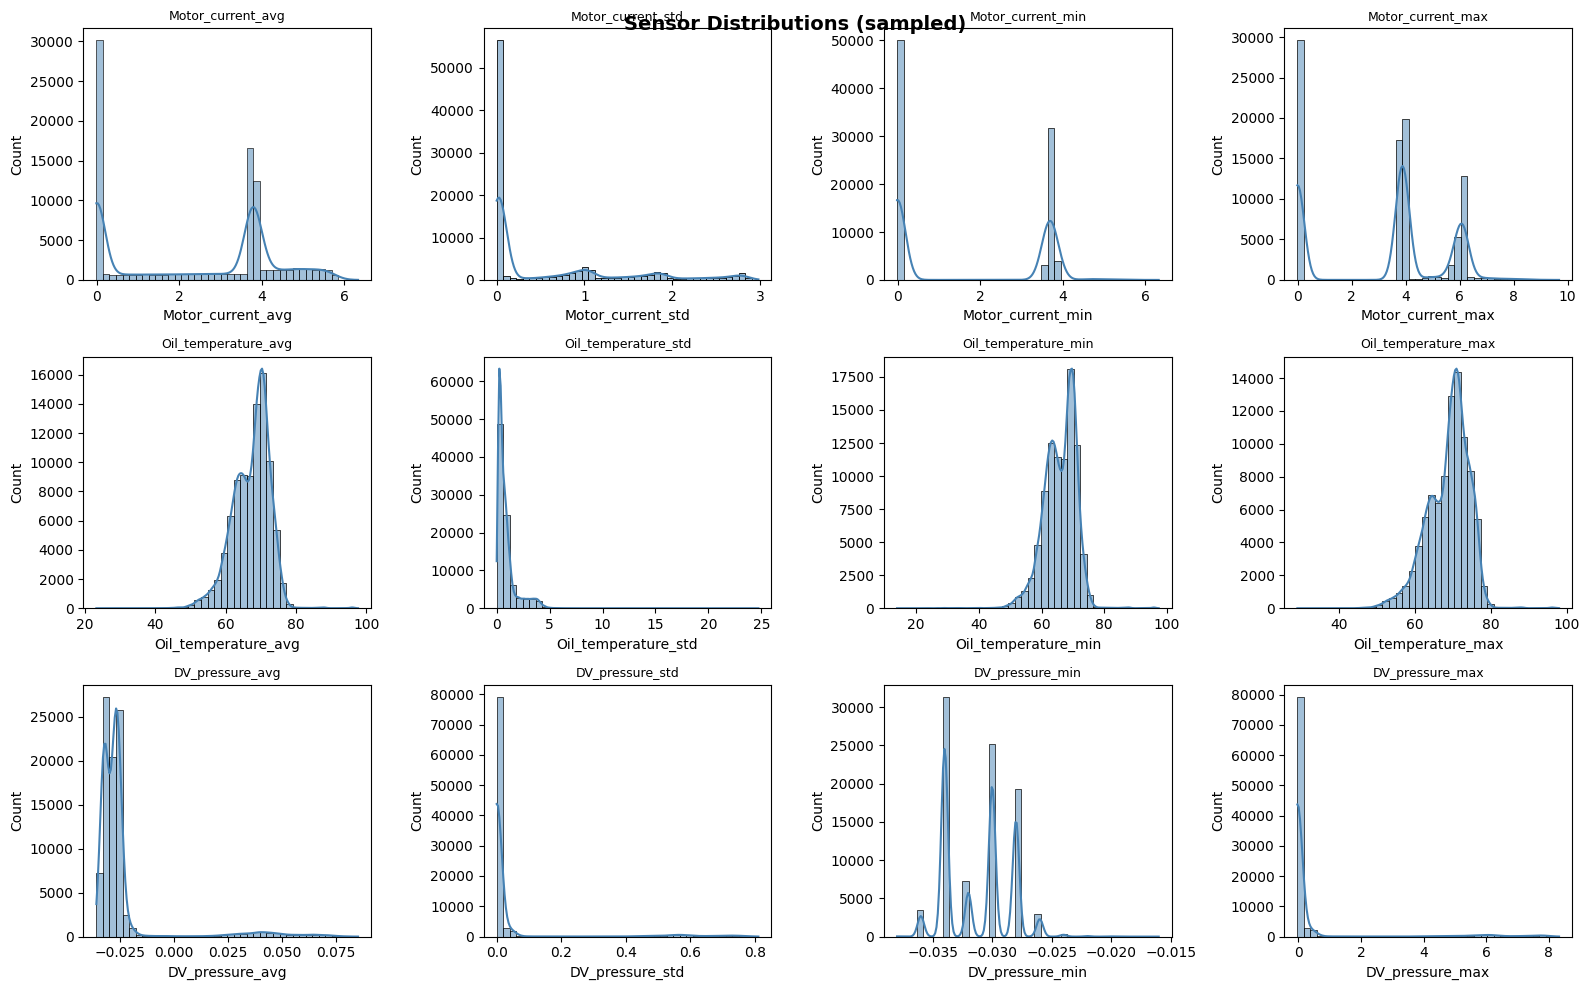

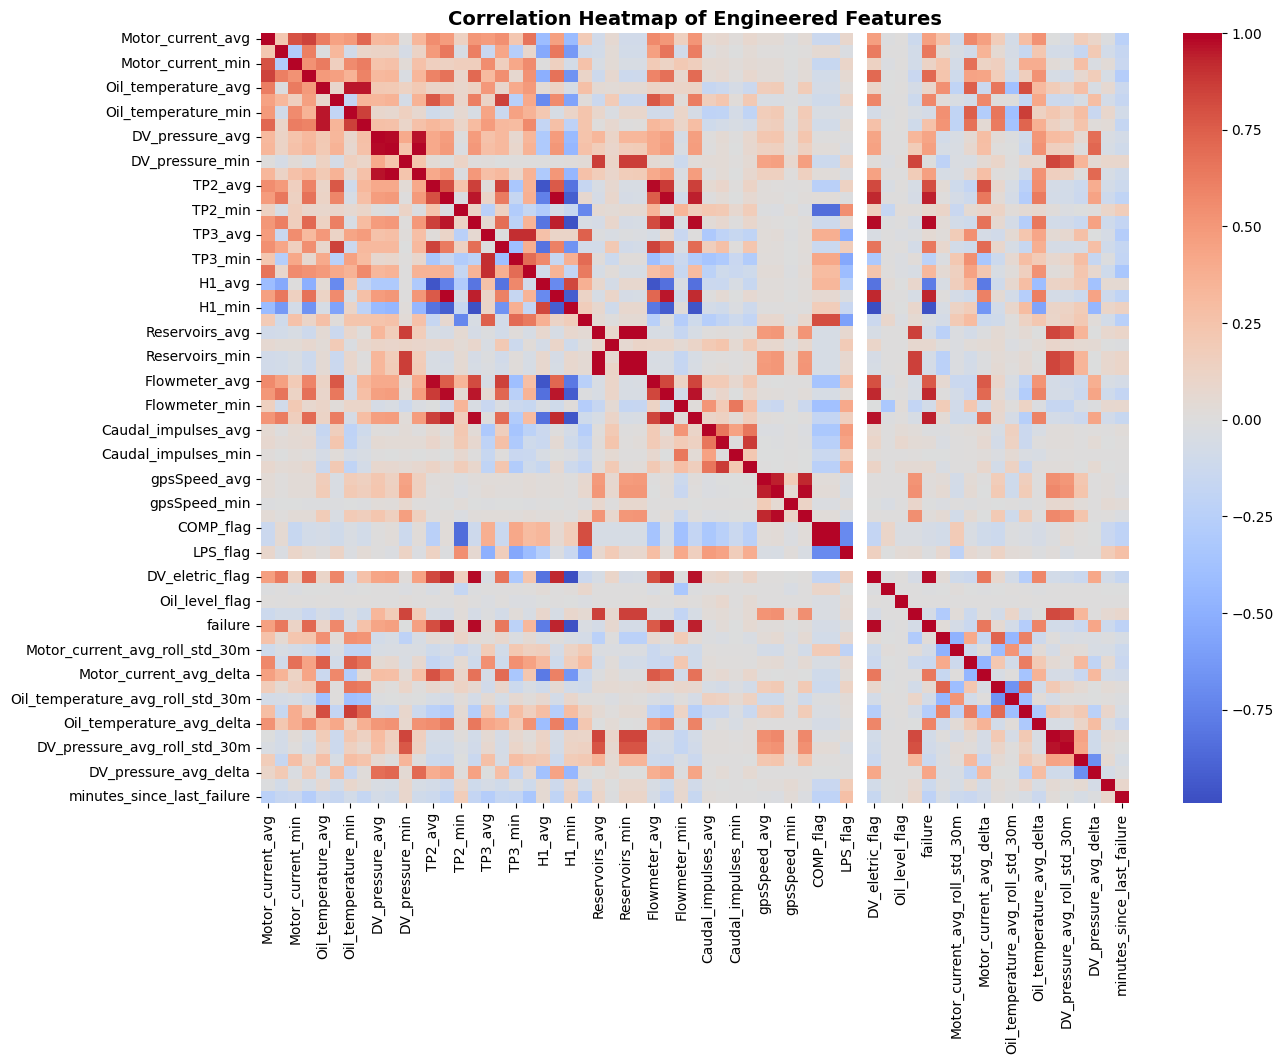

In [0]:
# --- Step 3: EDA (Part 2: Distributions + Correlations) ---

import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark → Pandas for plotting
pdf = df_final.toPandas()

# Select numeric features only
num_cols = [c for c in pdf.columns if pd.api.types.is_numeric_dtype(pdf[c])]

# --- Histograms for key sensors ---
plt.figure(figsize=(16, 10))
for i, col in enumerate(num_cols[:12]):  # show first 12 features as example
    plt.subplot(3, 4, i+1)
    sns.histplot(pdf[col].dropna(), bins=40, kde=True, color="steelblue")
    plt.title(col, fontsize=9)
    plt.tight_layout()
plt.suptitle("Sensor Distributions (sampled)", fontsize=14, weight="bold")
plt.show()

# --- Correlation heatmap ---
plt.figure(figsize=(14, 10))
corr = pdf[num_cols].corr()
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False, cbar=True)
plt.title("Correlation Heatmap of Engineered Features", fontsize=14, weight="bold")
plt.show()


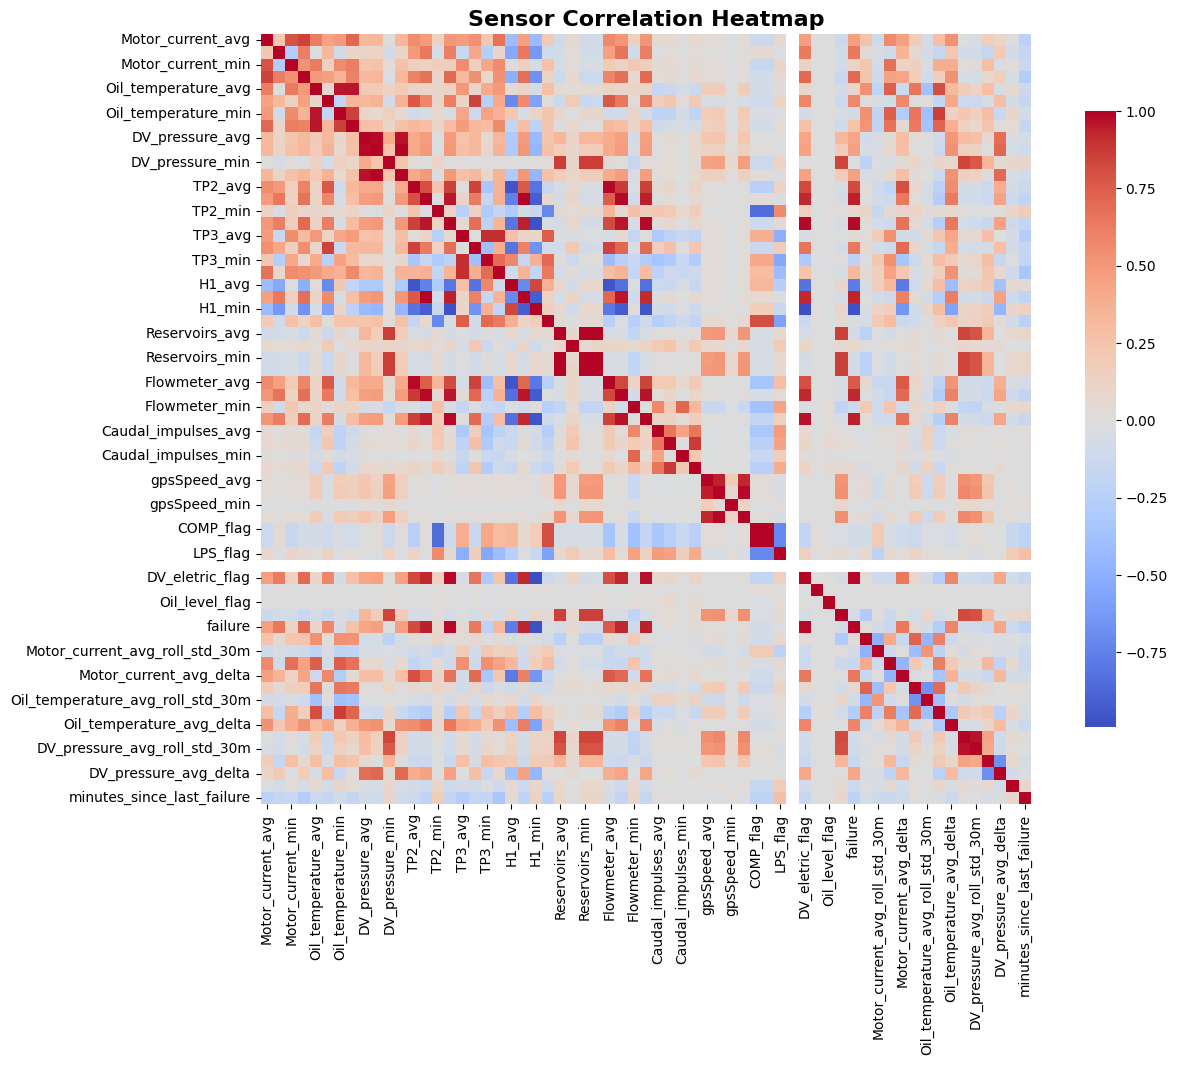

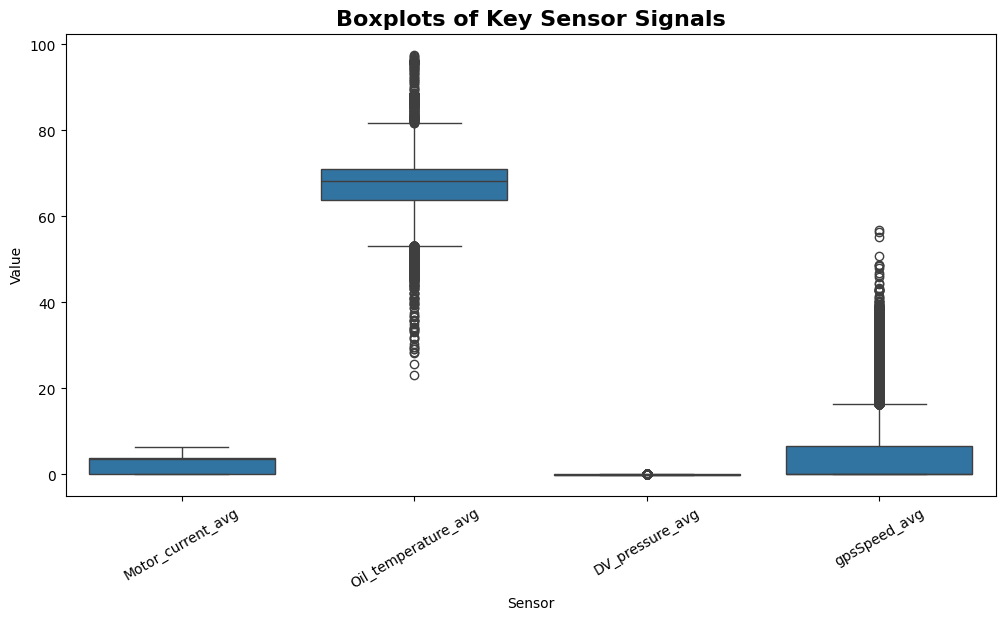

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Spark → Pandas (if not already done)
pdf = df_final.toPandas()

# Only numeric columns
num_cols = [c for c in pdf.columns if pd.api.types.is_numeric_dtype(pdf[c])]
pdf_num = pdf[num_cols].dropna()

# -----------------------------
# 1. Correlation Heatmap
# -----------------------------
plt.figure(figsize=(14, 10))
corr = pdf_num.corr()
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.8})
plt.title("Sensor Correlation Heatmap", fontsize=16, weight="bold")
plt.show()

# -----------------------------
# 2. Boxplots (subset of sensors)
# -----------------------------
sample_sensors = [
    "Motor_current_avg",
    "Oil_temperature_avg",
    "DV_pressure_avg",
    "gpsSpeed_avg"
]

plt.figure(figsize=(12, 6))
pdf_melt = pdf[sample_sensors].melt(var_name="Sensor", value_name="Value")
sns.boxplot(x="Sensor", y="Value", data=pdf_melt)
plt.title("Boxplots of Key Sensor Signals", fontsize=16, weight="bold")
plt.xticks(rotation=30)
plt.show()


In [0]:
from pyspark.sql import functions as F, Window

# Define window ordered by time
w = Window.orderBy("timestamp_hour") \
           .rowsBetween(0, Window.unboundedFollowing)

# Step 1. Find the next failure timestamp for each row
features = features.withColumn(
    "next_failure_time",
    F.min(F.when(F.col("failure") == 1, F.col("timestamp_hour"))).over(w)
)

# Step 2. Compute Remaining Useful Life (RUL) in hours
features = features.withColumn(
    "RUL_hours",
    F.when(
        F.col("next_failure_time").isNotNull(),
        (F.unix_timestamp("next_failure_time") - F.unix_timestamp("timestamp_hour")) / 3600
    )
)

# Step 3. Force failures to have RUL = 0
features = features.withColumn(
    "RUL_hours",
    F.when(F.col("failure") == 1, F.lit(0.0)).otherwise(F.col("RUL_hours"))
)

# Inspect
features.select("timestamp_hour", "failure", "next_failure_time", "RUL_hours").show(30, truncate=False)


/databricks/spark/python/pyspark/sql/connect/expressions.py:1061: UserWarning: WARN WindowExpression: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
  warnings.warn(


+-------------------+-------+-------------------+---------+
|timestamp_hour     |failure|next_failure_time  |RUL_hours|
+-------------------+-------+-------------------+---------+
|2022-01-01 06:00:00|1      |2022-01-01 06:00:00|0.0      |
|2022-01-01 07:00:00|1      |2022-01-01 07:00:00|0.0      |
|2022-01-01 08:00:00|1      |2022-01-01 08:00:00|0.0      |
|2022-01-01 09:00:00|1      |2022-01-01 09:00:00|0.0      |
|2022-01-01 10:00:00|1      |2022-01-01 10:00:00|0.0      |
|2022-01-01 11:00:00|1      |2022-01-01 11:00:00|0.0      |
|2022-01-01 12:00:00|1      |2022-01-01 12:00:00|0.0      |
|2022-01-01 13:00:00|1      |2022-01-01 13:00:00|0.0      |
|2022-01-01 14:00:00|1      |2022-01-01 14:00:00|0.0      |
|2022-01-01 15:00:00|1      |2022-01-01 15:00:00|0.0      |
|2022-01-01 16:00:00|1      |2022-01-01 16:00:00|0.0      |
|2022-01-01 17:00:00|1      |2022-01-01 17:00:00|0.0      |
|2022-01-01 18:00:00|1      |2022-01-01 18:00:00|0.0      |
|2022-01-01 19:00:00|1      |2022-01-01 

In [0]:
from pyspark.sql import functions as F, Window

# -----------------------------------
# 1) Load raw IoT and define failure
# -----------------------------------
raw_df = (
    spark.read.csv(
        "s3://hqpsusu-ml-data-bucket/raw/iot/metropt.csv",
        header=True,
        inferSchema=True
    )
)

# Failure at raw (COMP=0 & MPG=0 & LPS=0)
raw_df = raw_df.withColumn(
    "failure_raw",
    F.when((F.col("COMP") == 0) & (F.col("MPG") == 0) & (F.col("LPS") == 0), 1).otherwise(0)
)

# -----------------------------------
# 2) 2-minute bins
# -----------------------------------
raw_df = raw_df.withColumn(
    "timestamp_bin",
    (F.col("timestamp").cast("long") / 120).cast("long") * 120
)
raw_df = raw_df.withColumn("timestamp_bin", F.from_unixtime("timestamp_bin").cast("timestamp"))

# -----------------------------------
# 3) Aggregate rich features
#    - numeric: avg, std, min, max
#    - binary/state: max (presence)
# -----------------------------------
numeric_cols = [
    "Motor_current", "Oil_temperature", "DV_pressure",
    "TP2", "TP3", "H1", "Reservoirs", "Flowmeter",
    "Caudal_impulses", "gpsSpeed"
]

binary_cols = [
    "COMP", "MPG", "LPS", "Pressure_switch",
    "DV_eletric", "Towers", "Oil_level", "gpsQuality"
]

agg_exprs = []
for c in numeric_cols:
    agg_exprs += [
        F.avg(c).alias(f"{c}_avg"),
        F.stddev(c).alias(f"{c}_std"),
        F.min(c).alias(f"{c}_min"),
        F.max(c).alias(f"{c}_max"),
    ]
for c in binary_cols:
    agg_exprs += [F.max(F.col(c).cast("int")).alias(f"{c}_flag")]

# carry failure label to the bin
agg_exprs += [F.max("failure_raw").alias("failure")]

features = (
    raw_df.groupBy("timestamp_bin")
          .agg(*agg_exprs)
          .orderBy("timestamp_bin")
)

# -----------------------------------
# 4) Rolling stats, lags, deltas (30 min window on 2-min bins => last 15 rows)
# -----------------------------------
w_order = Window.orderBy("timestamp_bin")
w_roll_30m = w_order.rowsBetween(-15, -1)  # exclude current row

key_bases = [
    "Motor_current_avg",
    "Oil_temperature_avg",
    "DV_pressure_avg"
]

for base in key_bases:
    features = features.withColumn(f"{base}_roll_mean_30m", F.avg(F.col(base)).over(w_roll_30m))
    features = features.withColumn(f"{base}_roll_std_30m",  F.stddev(F.col(base)).over(w_roll_30m))
    features = features.withColumn(f"{base}_lag1",          F.lag(F.col(base), 1).over(w_order))
    features = features.withColumn(f"{base}_delta",         F.col(base) - F.col(f"{base}_lag1"))

# -----------------------------------
# 5) Next / last failure & RUL in minutes
# -----------------------------------
w_fwd  = Window.orderBy("timestamp_bin").rowsBetween(0, Window.unboundedFollowing)
w_back = Window.orderBy("timestamp_bin").rowsBetween(Window.unboundedPreceding, 0)

features = features.withColumn(
    "next_failure_time",
    F.first(F.when(F.col("failure") == 1, F.col("timestamp_bin")), ignorenulls=True).over(w_fwd)
)

features = features.withColumn(
    "last_failure_time",
    F.last(F.when(F.col("failure") == 1, F.col("timestamp_bin")), ignorenulls=True).over(w_back)
)

features = features.withColumn(
    "RUL_minutes",
    F.when(F.col("failure") == 1, F.lit(0.0))
     .otherwise((F.unix_timestamp("next_failure_time") - F.unix_timestamp("timestamp_bin")) / 60.0)
)

features = features.withColumn(
    "minutes_since_last_failure",
    (F.unix_timestamp("timestamp_bin") - F.unix_timestamp("last_failure_time")) / 60.0
)

# Optional: fill NA roll stats at the very beginning
fill_zero_cols = [f"{b}_roll_mean_30m" for b in key_bases] + [f"{b}_roll_std_30m" for b in key_bases] + \
                 [f"{b}_lag1" for b in key_bases] + [f"{b}_delta" for b in key_bases]
features = features.fillna(0, subset=fill_zero_cols)

# -----------------------------------
# 6) Final dataset
# -----------------------------------
df_final = features

# -----------------------------------
# 7) Preview & dimensions
# -----------------------------------
print("Schema:")
df_final.printSchema()

print("\nSample rows:")
df_final.show(10, truncate=False)

print("\nRow count:", df_final.count())
print("Column count:", len(df_final.columns))


com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$5(SequenceExecutionState.scala:132)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:132)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3$adapted(SequenceExecutionState.scala:129)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:129)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:715)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:435)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:435)
	at com.databricks.spark.chauffeur.ExecutionContextManagerV1.can

In [0]:
# Rows and columns before dropping non-feature columns
print("Full dataset shape:", pdf.shape)

# Rows and columns actually used for modeling (X only)
print("Feature matrix shape:", X.shape)

# Target vector length
print("Target vector length:", y.shape)

# Raw data dimensions
print("Raw row count:", iot_df.count())
print("Raw column count:", len(iot_df.columns))



Full dataset shape: (89926, 8)
Feature matrix shape: (89926, 4)
Target vector length: (89926,)
Raw row count: 10773588
Raw column count: 23


In [0]:
%pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/94.9 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.8/94.9 MB 24.1 MB/s eta 0:00:04
   ━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/94.9 MB 70.4 MB/s eta 0:00:02
   ━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/94.9 MB 76.7 MB/s eta 0:00:02
   ━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/94.9 MB 110.0 MB/s eta 0:00:01
   ━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/94.9 MB 113.2 MB/s eta 0:00:01
   ━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/94.9 MB 100.6 MB/s eta 0:00:01
   ━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.1/94.9 MB 108.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/94.9 MB 106.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/94.9 MB 103.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/94.9 MB 92.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━ 40.2/94.9 MB 103.4 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━ 43.7/94.9 MB 

Feature matrix shape: (89926, 62)  |  Train: (71940, 62)  Test: (17986, 62)
Target length: (89926,)
🏃 View run debonair-pug-951 at: https://dbc-4cb3b85d-ebc9.cloud.databricks.com/ml/experiments/779842787353078/runs/9e800cc1a8304e35888bfa337a79c907
🧪 View experiment at: https://dbc-4cb3b85d-ebc9.cloud.databricks.com/ml/experiments/779842787353078
RandomForest → MAE: 2.479 | RMSE: 12.940
XGBoost      → MAE: 3.039 | RMSE: 12.307


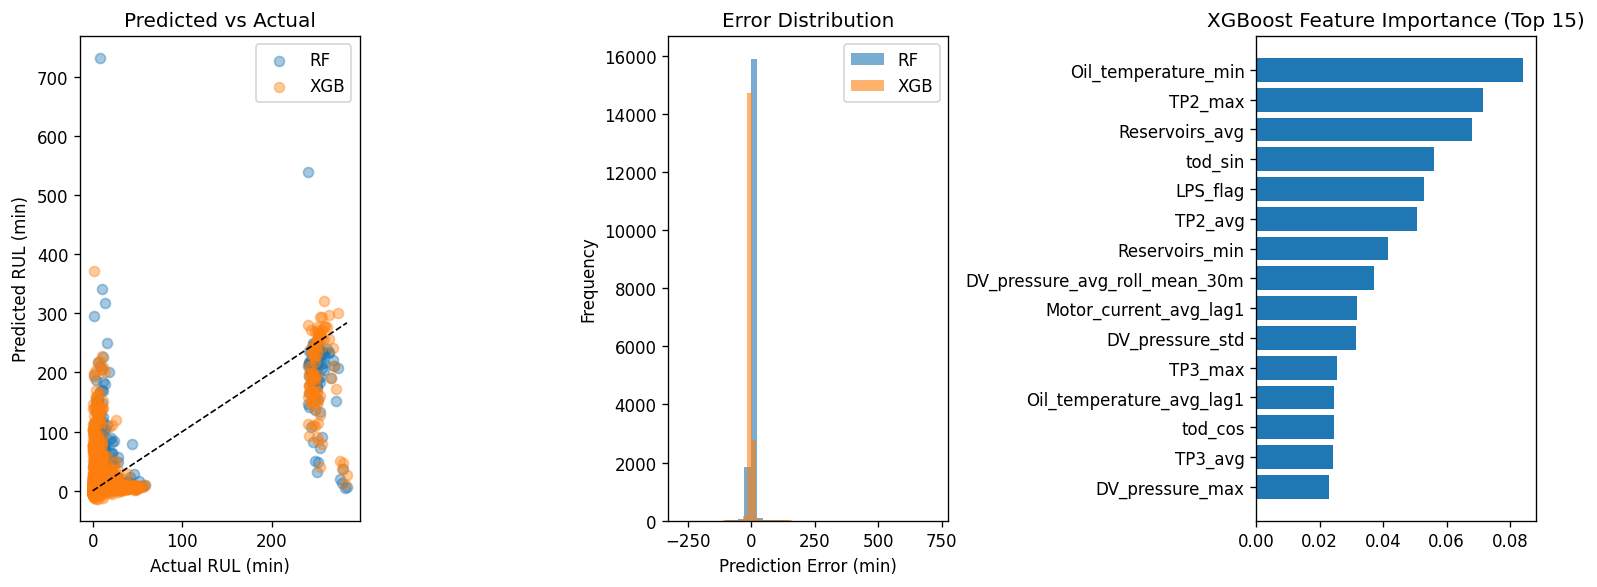


Top 20 features (RF):
tod_sin                              0.159729
TP3_std                              0.071493
Oil_temperature_min                  0.060295
Oil_temperature_avg_roll_mean_30m    0.043147
Motor_current_avg_lag1               0.040920
Motor_current_avg                    0.038172
H1_std                               0.035245
DV_pressure_std                      0.033116
TP3_max                              0.032689
TP2_avg                              0.032078
H1_min                               0.031904
tod_cos                              0.026076
Reservoirs_avg                       0.023973
Oil_temperature_avg_roll_std_30m     0.023696
Reservoirs_max                       0.021667
Flowmeter_avg                        0.021450
Oil_temperature_std                  0.020941
Motor_current_std                    0.018144
TP3_avg                              0.017057
Motor_current_max                    0.017027
dtype: float64

Top 20 features (XGB):
Oil_temperature_mi

In [0]:
# --- Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

plt.rcParams["figure.dpi"] = 120

# Handle RMSE deprecation in sklearn
try:
    from sklearn.metrics import root_mean_squared_error as rmse_fn
except Exception:
    def rmse_fn(y_true, y_pred):
        return mean_squared_error(y_true, y_pred, squared=False)

# =========================================================
# 1) Prepare training data
# =========================================================
train_df = df_final.filter(df_final["RUL_minutes"].isNotNull())
pdf = train_df.toPandas()

# Optional: time-of-day cyclic features
if "timestamp_bin" in pdf.columns:
    tod_min = pdf["timestamp_bin"].dt.hour * 60 + pdf["timestamp_bin"].dt.minute
    pdf["tod_sin"] = np.sin(2 * np.pi * tod_min / 1440.0)
    pdf["tod_cos"] = np.cos(2 * np.pi * tod_min / 1440.0)

drop_cols = [
    "timestamp_bin", 
    "failure", 
    "next_failure_time", 
    "last_failure_time", 
    "minutes_since_last_failure", 
    "RUL_minutes"
]
y = pdf["RUL_minutes"]

num_cols = [c for c in pdf.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(pdf[c])]
X = pdf[num_cols].copy()

# Train/test split (time-ordered)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Handle NaNs/infs
train_medians = X_train.median(numeric_only=True)
X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(train_medians)
X_test  = X_test.replace([np.inf, -np.inf], np.nan).fillna(train_medians)

print(f"Feature matrix shape: {X.shape}  |  Train: {X_train.shape}  Test: {X_test.shape}")
print(f"Target length: {y.shape}")

# =========================================================
# 2) Train models (faster configs)
# =========================================================
# Random Forest (shallower, fewer trees → faster)
rf = RandomForestRegressor(
    n_estimators=100,      # down from 300
    max_depth=12,          # limit depth (prevents super deep trees)
    n_jobs=-1,
    random_state=42
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# XGBoost (fewer rounds, faster learning rate)
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=200,      # down from 600
    learning_rate=0.1,     # faster learning per tree
    max_depth=5,           # shallower trees
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=-1,
    random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# =========================================================
# 3) Evaluate
# =========================================================
def evaluate(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = rmse_fn(y_true, y_pred)
    print(f"{name:12s} → MAE: {mae:.3f} | RMSE: {rmse:.3f}")
    return mae, rmse

mae_rf,  rmse_rf  = evaluate("RandomForest", y_test, y_pred_rf)
mae_xgb, rmse_xgb = evaluate("XGBoost",      y_test, y_pred_xgb)

# =========================================================
# 4) Visualizations
# =========================================================
plt.figure(figsize=(13,5))

# (a) Predicted vs Actual
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_rf, alpha=0.4, label="RF")
plt.scatter(y_test, y_pred_xgb, alpha=0.4, label="XGB")
mn, mx = float(y_test.min()), float(y_test.max())
plt.plot([mn, mx], [mn, mx], "k--", linewidth=1)
plt.xlabel("Actual RUL (min)")
plt.ylabel("Predicted RUL (min)")
plt.title("Predicted vs Actual")
plt.legend()

# (b) Error distribution
plt.subplot(1, 3, 2)
plt.hist(y_pred_rf - y_test, bins=40, alpha=0.6, label="RF")
plt.hist(y_pred_xgb - y_test, bins=40, alpha=0.6, label="XGB")
plt.xlabel("Prediction Error (min)")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.legend()

# (c) Feature importance (XGBoost top 15)
plt.subplot(1, 3, 3)
imp = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
topk = imp.sort_values(ascending=False).head(15)[::-1]
plt.barh(topk.index, topk.values)
plt.title("XGBoost Feature Importance (Top 15)")

plt.tight_layout()
plt.show()

# (Optional) Print top features
rf_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
xgb_imp = imp.sort_values(ascending=False).head(20)

print("\nTop 20 features (RF):")
print(rf_imp)

print("\nTop 20 features (XGB):")
print(xgb_imp)


In [0]:
%pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/887.9 MB ? eta -:--:--
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.3/887.9 MB 8.1 MB/s eta 0:01:49
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.6/887.9 MB 8.7 MB/s eta 0:01:42
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/887.9 MB 9.6 MB/s eta 0:01:33
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/887.9 MB 10.5 MB/s eta 0:01:25
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/887.9 MB 11.6 MB/s eta 0:01:17
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/887.9 MB 13.0 MB/s eta 0:01:08
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/887.9 MB 14.6 MB/s eta 0:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/887.9 MB 16.5 MB/s eta 0:00:54
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/887.9 MB 18.7 MB/s eta 0:00:48
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/887.9 MB 19.7 MB/s eta 0:00:45
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/887.9 MB 22.3 MB/s eta 0:00:40
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/887.9 MB 27.6 

ℹ️ Skipping LSTM due to: input.size(-1) must be equal to input_size. Expected 62, got 60
                     MAE    RMSE     R²  ...  ≤5 min %  ≤10 min %      N
Model                                    ...                            
RandomForest (S3)  2.479  12.940  0.511  ...    93.428     96.425  17986
XGBoost (S3)       3.039  12.307  0.558  ...    90.582     95.396  17986

[2 rows x 8 columns]


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


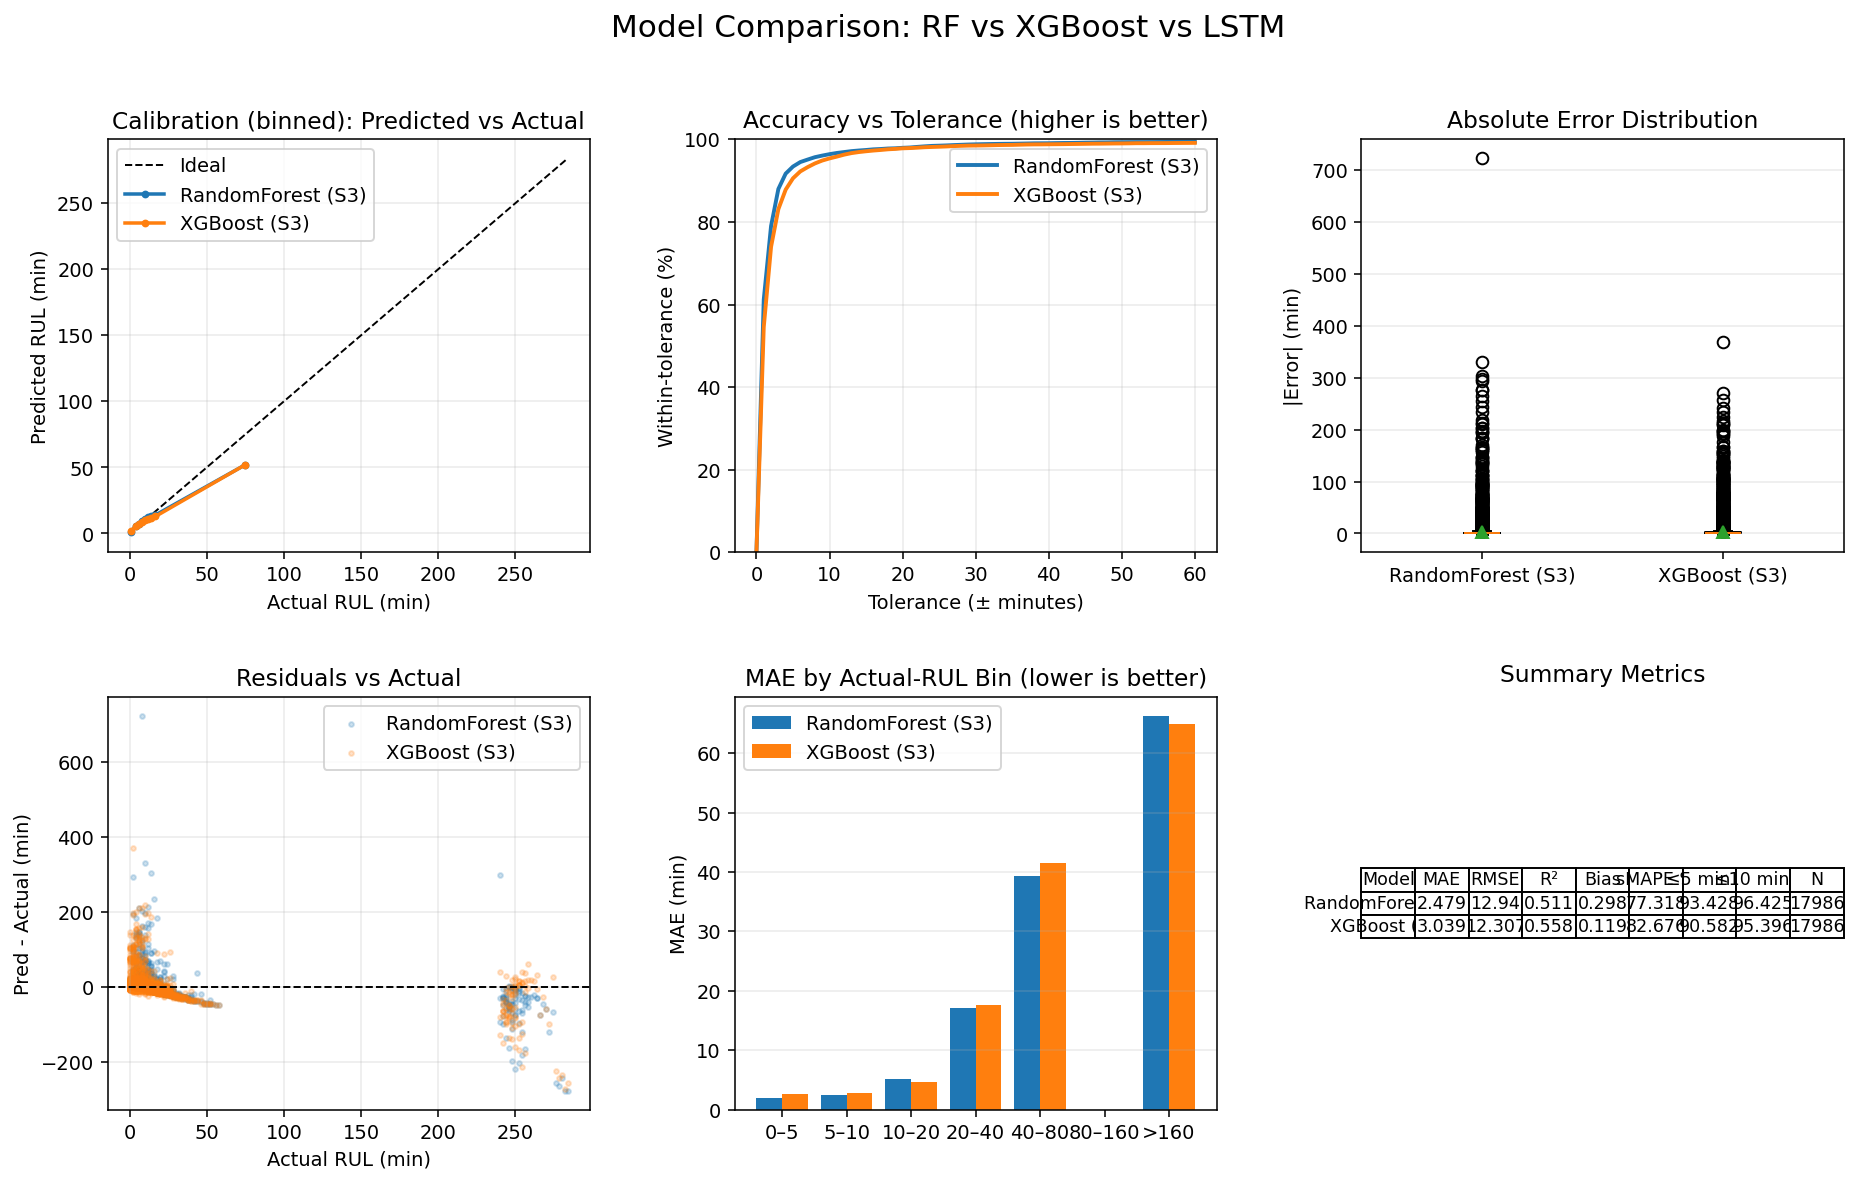

In [0]:
# ========= RF vs XGB vs LSTM (sequence) — unified comparison =========
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from io import BytesIO
import boto3, joblib, types

# ------------------------------
# 0) Load RF/XGB from S3 (joblib)
# ------------------------------
bucket = "hqpsusu-ml-data-bucket"
rf_key  = "final_project/models/rf_model.pkl"
xgb_key = "final_project/models/xgb_model.pkl"

def load_joblib_from_s3(bucket, key):
    buf = BytesIO()
    boto3.client("s3").download_fileobj(bucket, key, buf)
    buf.seek(0)
    return joblib.load(buf)

rf_loaded  = load_joblib_from_s3(bucket, rf_key)
xgb_loaded = load_joblib_from_s3(bucket, xgb_key)

# --------------------------------------
# 1) Produce predictions for each model
# --------------------------------------
models = {}

# A) Tabular models (same X_test / y_test)
y_true_tab = np.asarray(y_test)  # from your sklearn split
y_pred_rf  = rf_loaded.predict(X_test)
y_pred_xgb = xgb_loaded.predict(X_test)
models["RandomForest (S3)"] = (y_true_tab, y_pred_rf)
models["XGBoost (S3)"]      = (y_true_tab, y_pred_xgb)

# B) LSTM (sequence) — optional, only if the vars exist
try:
    import torch
    have = all(v in globals() for v in ["model", "X_test_t"])
    if have:
        # y_test for LSTM could be numpy (from your code) or torch tensor
        if "y_test" in globals() and isinstance(globals()["y_test"], (np.ndarray, list, pd.Series)):
            y_true_lstm = np.asarray(globals()["y_test"])
        elif "y_test_t" in globals():
            y_true_lstm = globals()["y_test_t"].detach().cpu().numpy()
        else:
            y_true_lstm = None

        with torch.no_grad():
            y_pred_lstm = model(X_test_t).detach().cpu().numpy()

        if y_true_lstm is not None and len(y_true_lstm) == len(y_pred_lstm):
            models["LSTM (seq)"] = (y_true_lstm, y_pred_lstm)
        else:
            print("ℹ️ LSTM found but y_test shapes not aligned — skipping LSTM in comparison.")
    else:
        print("ℹ️ LSTM variables not found — skipping LSTM in comparison.")
except Exception as e:
    print(f"ℹ️ Skipping LSTM due to: {e}")

# --------------------------------------
# 2) Metrics
# --------------------------------------
def metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask   = np.isfinite(y_true) & np.isfinite(y_pred)
    yt, yp = y_true[mask], y_pred[mask]
    err, ae = (yp - yt), np.abs(yp - yt)
    eps = 1e-9
    return {
        "MAE": mean_absolute_error(yt, yp),
        "RMSE": mean_squared_error(yt, yp, squared=False),
        "R²": r2_score(yt, yp),
        "Bias": float(err.mean()),
        "sMAPE %": 100.0 * np.mean(2*ae / (np.abs(yt)+np.abs(yp)+eps)),
        "≤5 min %": 100.0 * np.mean(ae <= 5),
        "≤10 min %": 100.0 * np.mean(ae <= 10),
        "N": int(yt.size),
    }

summary_rows = []
for name, (yt, yp) in models.items():
    m = metrics(yt, yp); m["Model"] = name
    summary_rows.append(m)
results = pd.DataFrame(summary_rows).set_index("Model").round(3).sort_values("MAE")
print(results)

# --------------------------------------
# 3) Helpers for plots
# --------------------------------------
def binned_xy(y_true, y_pred, nbins=40):
    df = pd.DataFrame({"y": y_true, "yp": y_pred}).dropna()
    q = min(nbins, max(2, int(df.shape[0]**0.5)))
    df["bin"] = pd.qcut(df["y"], q=q, duplicates="drop")
    g = df.groupby("bin").agg(y_mean=("y","mean"), yp_mean=("yp","mean"))
    return g["y_mean"].values, g["yp_mean"].values

plt.rcParams["figure.dpi"] = 140
fig = plt.figure(figsize=(16, 9))
grid = fig.add_gridspec(2, 3, hspace=0.35, wspace=0.3)

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
names  = list(models.keys())

# 3A) Calibration (binned)
ax1 = fig.add_subplot(grid[0,0])
mn = min(np.min(v[0]) for v in models.values())
mx = max(np.max(v[0]) for v in models.values())
ax1.plot([mn, mx], [mn, mx], "k--", lw=1, label="Ideal")
for (name, (yt, yp)), c in zip(models.items(), colors):
    xb, yb = binned_xy(yt, yp)
    ax1.plot(xb, yb, marker="o", ms=3, lw=1.8, label=name, color=c)
ax1.set_title("Calibration (binned): Predicted vs Actual")
ax1.set_xlabel("Actual RUL (min)"); ax1.set_ylabel("Predicted RUL (min)")
ax1.legend(); ax1.grid(alpha=0.25)

# 3B) Accuracy vs Tolerance (CDF style)
ax2 = fig.add_subplot(grid[0,1])
tol = np.arange(0, 61, 1)
for (name, (yt, yp)), c in zip(models.items(), colors):
    ae = np.abs(yp - yt)
    acc = [(ae <= t).mean()*100.0 for t in tol]
    ax2.plot(tol, acc, lw=2, label=name, color=c)
ax2.set_title("Accuracy vs Tolerance (higher is better)")
ax2.set_xlabel("Tolerance (± minutes)"); ax2.set_ylabel("Within-tolerance (%)")
ax2.set_ylim(0, 100); ax2.legend(); ax2.grid(alpha=0.25)

# 3C) Absolute error distributions (boxplot)
ax3 = fig.add_subplot(grid[0,2])
box_data = [np.abs(models[n][1] - models[n][0]) for n in names]
ax3.boxplot(box_data, labels=names, showmeans=True)
ax3.set_title("Absolute Error Distribution"); ax3.set_ylabel("|Error| (min)")
ax3.grid(axis="y", alpha=0.25)

# 3D) Residuals vs Actual
ax4 = fig.add_subplot(grid[1,0])
for (name, (yt, yp)), c in zip(models.items(), colors):
    ax4.scatter(yt, (yp - yt), s=6, alpha=0.22, label=name, color=c)
ax4.axhline(0, color="k", ls="--", lw=1)
ax4.set_title("Residuals vs Actual"); ax4.set_xlabel("Actual RUL (min)"); ax4.set_ylabel("Pred - Actual (min)")
ax4.legend(); ax4.grid(alpha=0.25)

# 3E) MAE by Actual-RUL bins
ax5 = fig.add_subplot(grid[1,1])
bins = [0, 5, 10, 20, 40, 80, 160, 9999]
labels = ["0–5","5–10","10–20","20–40","40–80","80–160",">160"]
x = np.arange(len(labels)); w = 0.8 / max(1, len(names))
for i, ((name, (yt, yp)), c) in enumerate(zip(models.items(), colors)):
    idx = np.digitize(yt, bins, right=True) - 1
    dfb = pd.DataFrame({"bin": idx, "ae": np.abs(yp - yt)})
    mae_bins = dfb.groupby("bin")["ae"].mean().reindex(range(len(labels))).values
    ax5.bar(x + (i - (len(names)-1)/2)*w, mae_bins, width=w, label=name, color=c)
ax5.set_xticks(x, labels); ax5.set_ylabel("MAE (min)")
ax5.set_title("MAE by Actual-RUL Bin (lower is better)")
ax5.legend(); ax5.grid(axis="y", alpha=0.25)

# 3F) Metrics table
ax6 = fig.add_subplot(grid[1,2]); ax6.axis("off")
tbl = ax6.table(cellText=results.reset_index().values,
                colLabels=["Model"] + list(results.columns),
                cellLoc="center", loc="center")
tbl.auto_set_font_size(False); tbl.set_fontsize(9)
ax6.set_title("Summary Metrics", pad=8)

plt.suptitle("Model Comparison: RF vs XGBoost vs LSTM", fontsize=16, y=0.98)
plt.show()


In [0]:
# ---- Make LSTM use the exact same split as RF/XGB and add it to comparison ----
import numpy as np, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1) Reconstruct the full, already-imputed matrix & target
X_full = np.vstack([np.asarray(X_train), np.asarray(X_test)])
y_full = np.concatenate([np.asarray(y_train), np.asarray(y_test)])
cut    = len(y_train)                      # same cutoff as RF/XGB
SEQ_LEN = 30

# 2) Build rolling sequences whose TARGET index aligns with the same cutoff
Xs, ys, tgt = [], [], []
for i in range(len(X_full) - SEQ_LEN):
    Xs.append(X_full[i:i+SEQ_LEN])
    ys.append(y_full[i+SEQ_LEN])
    tgt.append(i + SEQ_LEN)
Xs, ys, tgt = np.array(Xs), np.array(ys), np.array(tgt)

mask_test  = tgt >= cut                    # targets on/after the cutoff → test
Xseq_tr, Yseq_tr = Xs[~mask_test], ys[~mask_test]
Xseq_te, Yseq_te = Xs[mask_test], ys[mask_test]

assert len(Yseq_te) == len(y_test), "LSTM test size must match RF/XGB test size"

# 3) Normalize using TRAIN sequences only
mu  = Xseq_tr.mean(axis=(0,1), keepdims=True)
std = Xseq_tr.std(axis=(0,1),  keepdims=True); std[std==0] = 1e-6
Xseq_tr = (Xseq_tr - mu)/std
Xseq_te = (Xseq_te - mu)/std

# 4) Tiny LSTM
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden=64, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(n_features, hidden, num_layers=layers, batch_first=True, dropout=0.2)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze(-1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMRegressor(n_features=Xseq_tr.shape[2]).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
lossf = nn.MSELoss()

train_ds = TensorDataset(torch.tensor(Xseq_tr, dtype=torch.float32),
                         torch.tensor(Yseq_tr, dtype=torch.float32))
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True)

model.train()
for epoch in range(6):  # quick fit
    epoch_loss = 0.0
    for xb, yb in train_ld:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = lossf(pred, yb)
        loss.backward(); opt.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}: loss={epoch_loss/len(train_ld):.4f}")

# 5) Predict on SAME test span as RF/XGB
model.eval()
with torch.no_grad():
    y_pred_lstm = model(torch.tensor(Xseq_te, dtype=torch.float32, device=device)).cpu().numpy()

# 6) Add to your existing comparison dict & re-plot (reuse your earlier block)
models["LSTM (seq)"] = (Yseq_te, y_pred_lstm)

# Re-run the metrics + plotting cell you used for RF/XGB (no other changes needed).


Epoch 1: loss=2159.4597
Epoch 2: loss=2083.2468
Epoch 3: loss=2033.9607
Epoch 4: loss=1983.7744
Epoch 5: loss=1930.5663
Epoch 6: loss=1886.5211


✅ Summary metrics (lower is better):


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


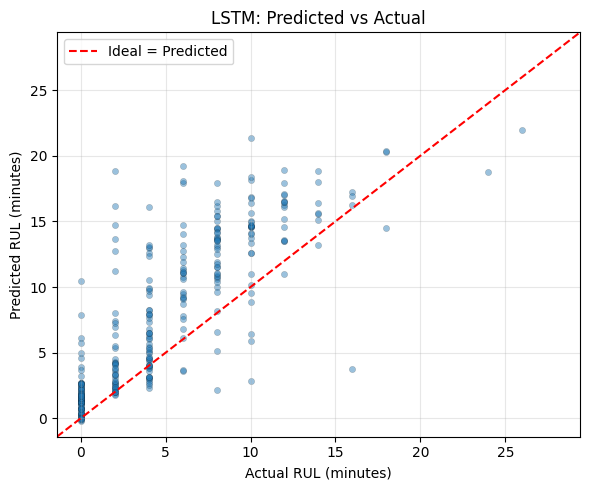

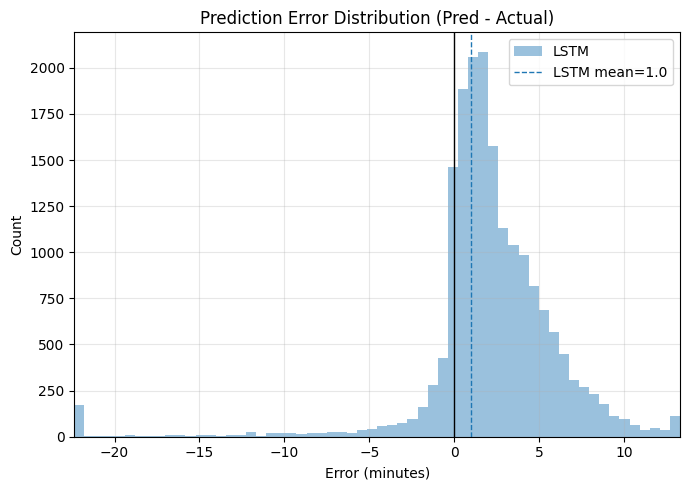

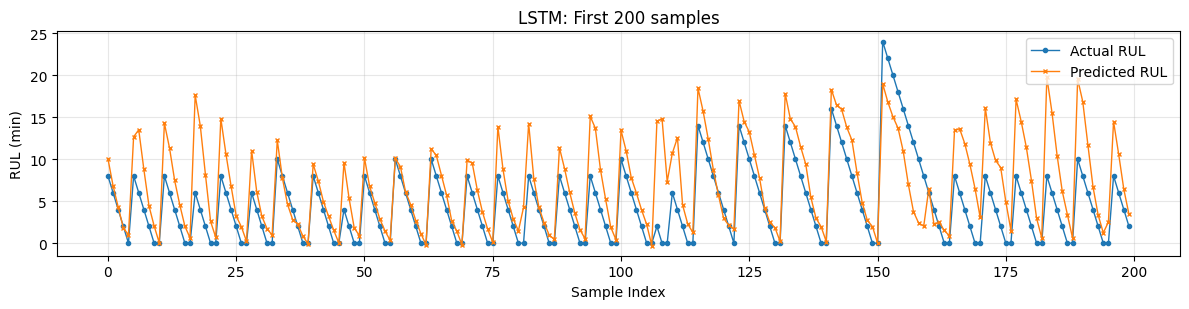

ℹ️ No LSTM epoch loss history found. To record it, append the mean batch loss each epoch to `epoch_losses` during training.


In [0]:
# ============================
# Presentation-ready comparison
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ---- Helper: register any (name, y_true, y_pred) that truly align ----
pairs = []

def add_pair(name, y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    if len(y_true) != len(y_pred):
        print(f"⚠️ Skipping {name}: length mismatch y_true={len(y_true)} vs y_pred={len(y_pred)}")
        return
    if not np.isfinite(y_true).all() or not np.isfinite(y_pred).all():
        mask = np.isfinite(y_true) & np.isfinite(y_pred)
        print(f"ℹ️ {name}: dropping {np.size(mask)-mask.sum()} non-finite rows")
        y_true, y_pred = y_true[mask], y_pred[mask]
    pairs.append({"name": name, "y_true": y_true, "y_pred": y_pred})

# ---- Try to collect models that may exist in your notebook ----
# Classical models (RF/XGB) usually share the same y_test_tab/y_test_classic. Adjust names if needed.
if "y_pred_rf" in locals() and "y_test" in locals():
    add_pair("Random Forest", y_test, y_pred_rf)
if "y_pred_xgb" in locals() and "y_test" in locals():
    add_pair("XGBoost", y_test, y_pred_xgb)

# LSTM: if you used the snippet where LSTM reused 'y_test' and 'y_pred',
# we try both common possibilities:
if "y_pred_lstm" in locals() and "y_test_lstm" in locals():
    add_pair("LSTM", y_test_lstm, y_pred_lstm)
elif "y_pred" in locals() and "y_test" in locals():
    add_pair("LSTM", y_test, y_pred)

if not pairs:
    raise RuntimeError("No valid (y_true, y_pred) pairs found. Make sure prediction variables are in memory.")

# ---- Metrics table ----
def smape(y_true, y_pred, eps=1e-6):
    denom = (np.abs(y_true) + np.abs(y_pred) + eps)
    return 100.0 * np.mean(np.abs(y_pred - y_true) / denom)

rows = []
for p in pairs:
    yt, yp = p["y_true"], p["y_pred"]
    mae  = mean_absolute_error(yt, yp)
    rmse = mean_squared_error(yt, yp, squared=False)
    bias = float(np.mean(yp - yt))
    s_mape = smape(yt, yp)
    rows.append({"Model": p["name"], "MAE (min)": mae, "RMSE (min)": rmse, "Bias (min)": bias, "sMAPE (%)": s_mape})

metrics_df = pd.DataFrame(rows).sort_values("RMSE (min)").reset_index(drop=True)
print("✅ Summary metrics (lower is better):")
display(metrics_df.style.format({"MAE (min)": "{:.2f}", "RMSE (min)": "{:.2f}", "Bias (min)": "{:.2f}", "sMAPE (%)": "{:.1f}"}))

# ---- Global ranges for comparable axes ----
all_true = np.concatenate([p["y_true"] for p in pairs])
low, high = np.percentile(all_true, [1, 99])
pad = 0.05 * (high - low + 1e-6)
xy_min, xy_max = low - pad, high + pad

# Error range (clip for readability, but still show full histogram tails via bins)
all_err = np.concatenate([p["y_pred"] - p["y_true"] for p in pairs])
e_low, e_high = np.percentile(all_err, [1, 99])
e_pad = 0.05 * (e_high - e_low + 1e-6)
err_min, err_max = e_low - e_pad, e_high + e_pad

# ---- Figure 1: Per-model Predicted vs Actual ----
cols = len(pairs)
fig, axes = plt.subplots(1, cols, figsize=(6*cols, 5))
axes = np.atleast_1d(axes)

for ax, p in zip(axes, pairs):
    yt, yp, name = p["y_true"], p["y_pred"], p["name"]
    # subsample for readability if huge
    n = len(yt)
    idx = np.linspace(0, n-1, min(n, 300)).astype(int)
    ax.scatter(yt[idx], yp[idx], alpha=0.45, s=20, edgecolor="k", linewidths=0.2)
    ax.plot([xy_min, xy_max], [xy_min, xy_max], "r--", lw=1.5, label="Ideal = Predicted")
    ax.set_xlim(xy_min, xy_max)
    ax.set_ylim(xy_min, xy_max)
    ax.set_title(f"{name}: Predicted vs Actual")
    ax.set_xlabel("Actual RUL (minutes)")
    ax.set_ylabel("Predicted RUL (minutes)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

# ---- Figure 2: Overlaid Error Histogram (all models) ----
plt.figure(figsize=(7,5))
bins = 60
for p in pairs:
    err = p["y_pred"] - p["y_true"]
    plt.hist(np.clip(err, err_min, err_max), bins=bins, alpha=0.45, label=p["name"])
# vertical line at 0 and per-model mean bias
plt.axvline(0, color="k", lw=1)
for p in pairs:
    mu = float(np.mean(p["y_pred"] - p["y_true"]))
    plt.axvline(mu, linestyle="--", lw=1, label=f"{p['name']} mean={mu:.1f}")
plt.xlim(err_min, err_max)
plt.title("Prediction Error Distribution (Pred - Actual)")
plt.xlabel("Error (minutes)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---- Figure 3: Time-slice (first N samples) ----
N = 200
fig, axes = plt.subplots(len(pairs), 1, figsize=(12, 3.2*len(pairs)), sharex=True)
axes = np.atleast_1d(axes)
for ax, p in zip(axes, pairs):
    yt, yp = p["y_true"][:N], p["y_pred"][:N]
    ax.plot(yt, marker="o", ms=3, lw=1, label="Actual RUL")
    ax.plot(yp, marker="x", ms=3, lw=1, label="Predicted RUL")
    ax.set_title(f"{p['name']}: First {N} samples")
    ax.set_ylabel("RUL (min)")
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Sample Index")
axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()

# ---- Optional: LSTM training loss curve if you tracked epoch_losses ----
if "epoch_losses" in locals() and len(epoch_losses) > 0:
    plt.figure(figsize=(7,4))
    plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker="o")
    plt.title("LSTM Training Loss (per epoch)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("ℹ️ No LSTM epoch loss history found. To record it, append the mean batch loss each epoch to `epoch_losses` during training.")


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


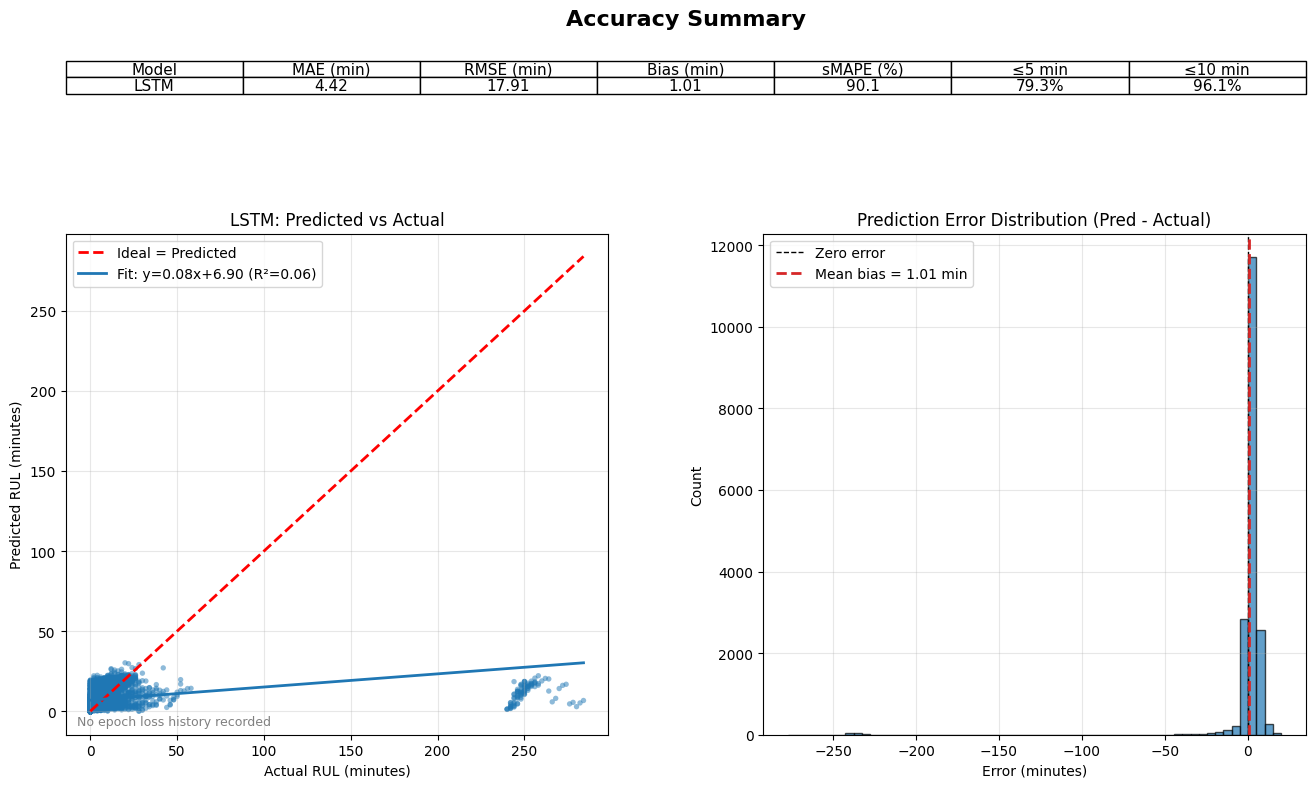

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ============================================================
# 1) Compute metrics safely
# ============================================================
eps = 1e-6
mask = np.isfinite(y_test) & np.isfinite(y_pred)
yt = np.asarray(y_test)[mask]
yp = np.asarray(y_pred)[mask]

errors = yp - yt
abs_err = np.abs(errors)

mae  = mean_absolute_error(yt, yp)
rmse = mean_squared_error(yt, yp, squared=False)
bias = float(np.mean(errors))
smape = 100.0 * np.mean(2.0 * abs_err / (np.abs(yt) + np.abs(yp) + eps))
pct_w5  = 100.0 * np.mean(abs_err <= 5)
pct_w10 = 100.0 * np.mean(abs_err <= 10)

# calibration fit
coef = np.polyfit(yt, yp, deg=1) if yt.size > 1 else [0, 0]
fit_fn = np.poly1d(coef)
r2 = r2_score(yt, yp) if yt.size > 1 else 0.0

# ============================================================
# 2) Plotting
# ============================================================
plt.style.use("default")
fig = plt.figure(figsize=(16, 9))
grid = fig.add_gridspec(3, 4, height_ratios=[0.6, 1.6, 1.6], hspace=0.8, wspace=0.8)

# (A) Metric header table
ax_head = fig.add_subplot(grid[0, :])
ax_head.axis("off")
summary = pd.DataFrame([{
    "Model": "LSTM",
    "MAE (min)": f"{mae:.2f}",
    "RMSE (min)": f"{rmse:.2f}",
    "Bias (min)": f"{bias:.2f}",
    "sMAPE (%)": f"{smape:.1f}",
    "≤5 min": f"{pct_w5:.1f}%",
    "≤10 min": f"{pct_w10:.1f}%"
}])
tbl = ax_head.table(cellText=summary.values, colLabels=summary.columns,
                    cellLoc="center", loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
ax_head.set_title("Accuracy Summary", pad=12, fontsize=16, weight="bold")

# (B) Predicted vs Actual scatter
ax_sc = fig.add_subplot(grid[1:, 0:2])
if yt.size > 0:
    ax_sc.scatter(yt, yp, s=15, alpha=0.5, edgecolors="none")
    mn, mx = float(np.min(yt)), float(np.max(yt))
    ax_sc.plot([mn, mx], [mn, mx], "r--", lw=2, label="Ideal = Predicted")
    if yt.size > 5:
        xx = np.linspace(mn, mx, 100)
        ax_sc.plot(xx, fit_fn(xx), lw=2,
                   label=f"Fit: y={coef[0]:.2f}x+{coef[1]:.2f} (R²={r2:.2f})")
    ax_sc.set_xlabel("Actual RUL (minutes)")
    ax_sc.set_ylabel("Predicted RUL (minutes)")
    ax_sc.set_title("LSTM: Predicted vs Actual")
    ax_sc.grid(True, alpha=0.3)
    ax_sc.legend(loc="upper left")
else:
    ax_sc.text(0.5, 0.5, "No valid test samples", ha="center", va="center")
    ax_sc.set_axis_off()

# (C) Error histogram
ax_err = fig.add_subplot(grid[1:, 2:])
if errors.size > 0:
    ax_err.hist(errors, bins=60, edgecolor="black", alpha=0.7)
    ax_err.axvline(0, color="k", linestyle="--", linewidth=1, label="Zero error")
    ax_err.axvline(errors.mean(), color="tab:red", linestyle="--", linewidth=2,
                   label=f"Mean bias = {errors.mean():.2f} min")
    ax_err.set_title("Prediction Error Distribution (Pred - Actual)")
    ax_err.set_xlabel("Error (minutes)")
    ax_err.set_ylabel("Count")
    ax_err.grid(True, alpha=0.3)
    ax_err.legend()
else:
    ax_err.text(0.5, 0.5, "No errors to display", ha="center", va="center")
    ax_err.set_axis_off()

# (D) Epoch loss inset (if collected)
if "epoch_losses" in globals() and len(epoch_losses) > 0:
    inset = ax_sc.inset_axes([0.55, 0.05, 0.4, 0.35])
    inset.plot(range(1, len(epoch_losses)+1), epoch_losses, marker="o", ms=3)
    inset.set_title("Epoch Loss", fontsize=10)
    inset.set_xlabel("Epoch", fontsize=9)
    inset.set_ylabel("MSE", fontsize=9)
    inset.grid(True, alpha=0.3)
else:
    ax_sc.text(0.02, 0.02, "No epoch loss history recorded",
               transform=ax_sc.transAxes, fontsize=9, color="gray")

plt.show()


Features: 62 | Train (71940, 62) | Test (17986, 62)
🏃 View run nervous-stoat-17 at: https://dbc-4cb3b85d-ebc9.cloud.databricks.com/ml/experiments/779842787353078/runs/60d36077d2d64556bcb022ba94393f89
🧪 View experiment at: https://dbc-4cb3b85d-ebc9.cloud.databricks.com/ml/experiments/779842787353078
Epoch 1: loss=2162.6240
Epoch 2: loss=2085.7705
Epoch 3: loss=2031.4973
Epoch 4: loss=1990.6027
Epoch 5: loss=1932.8834
Epoch 6: loss=1895.2054


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


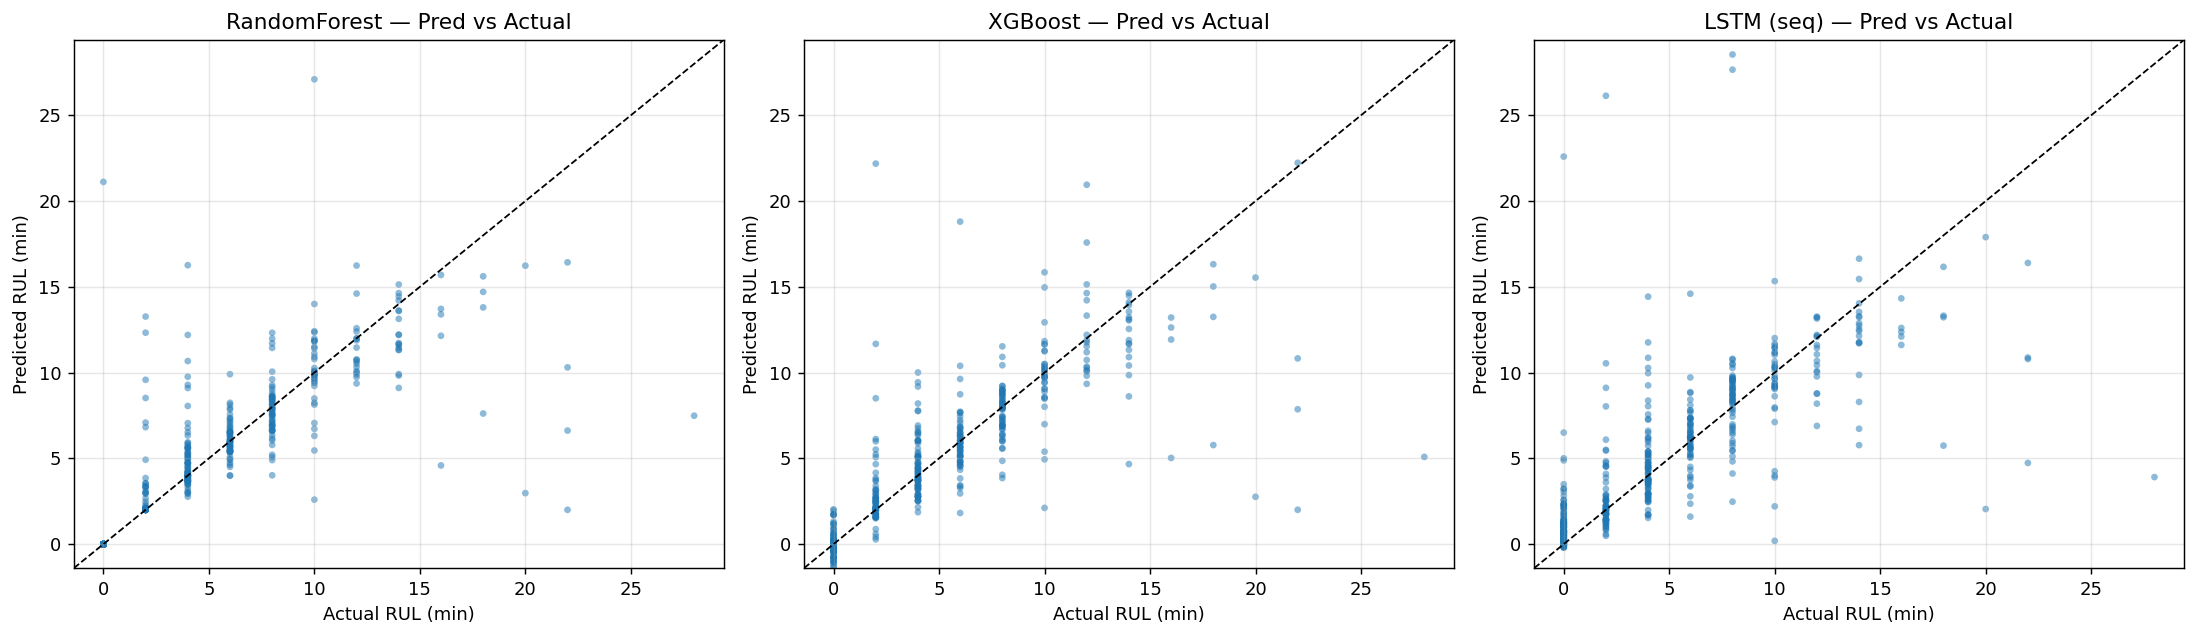

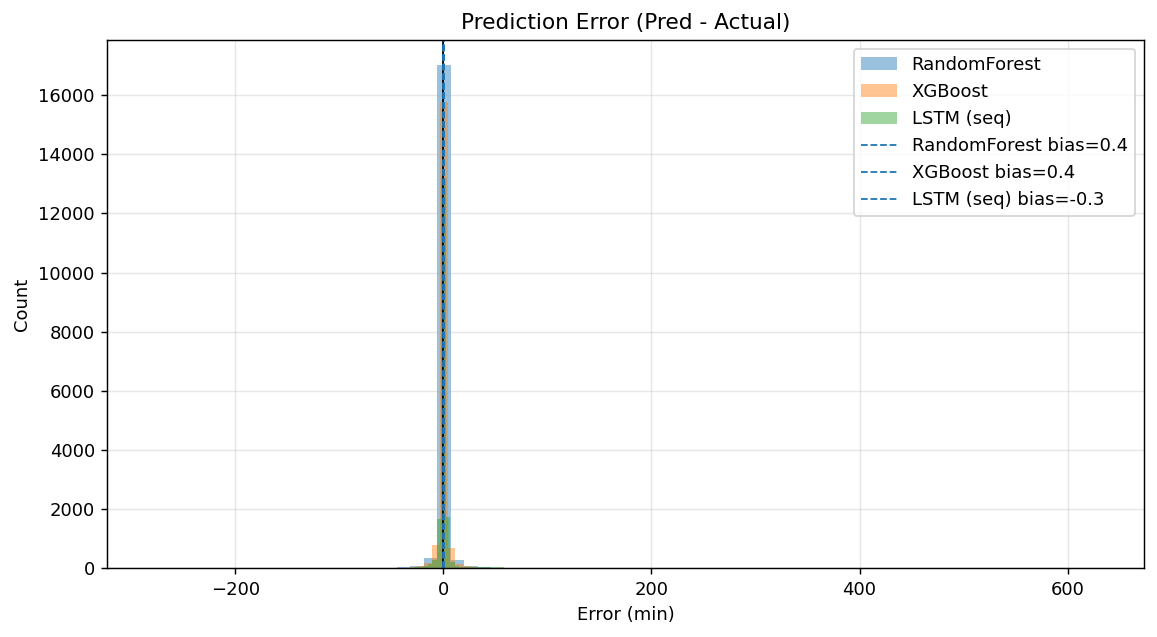

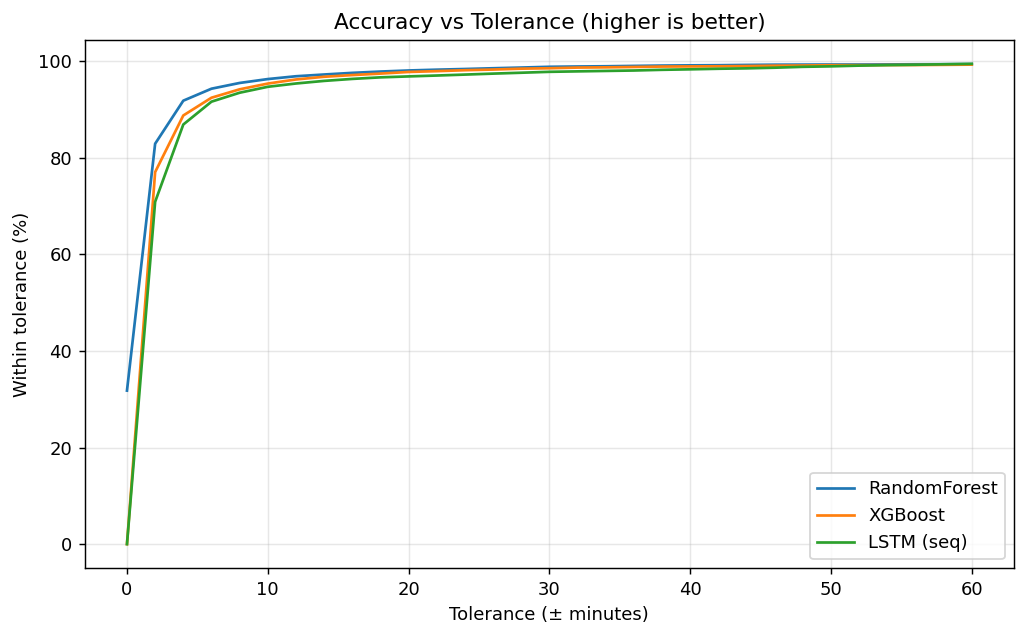

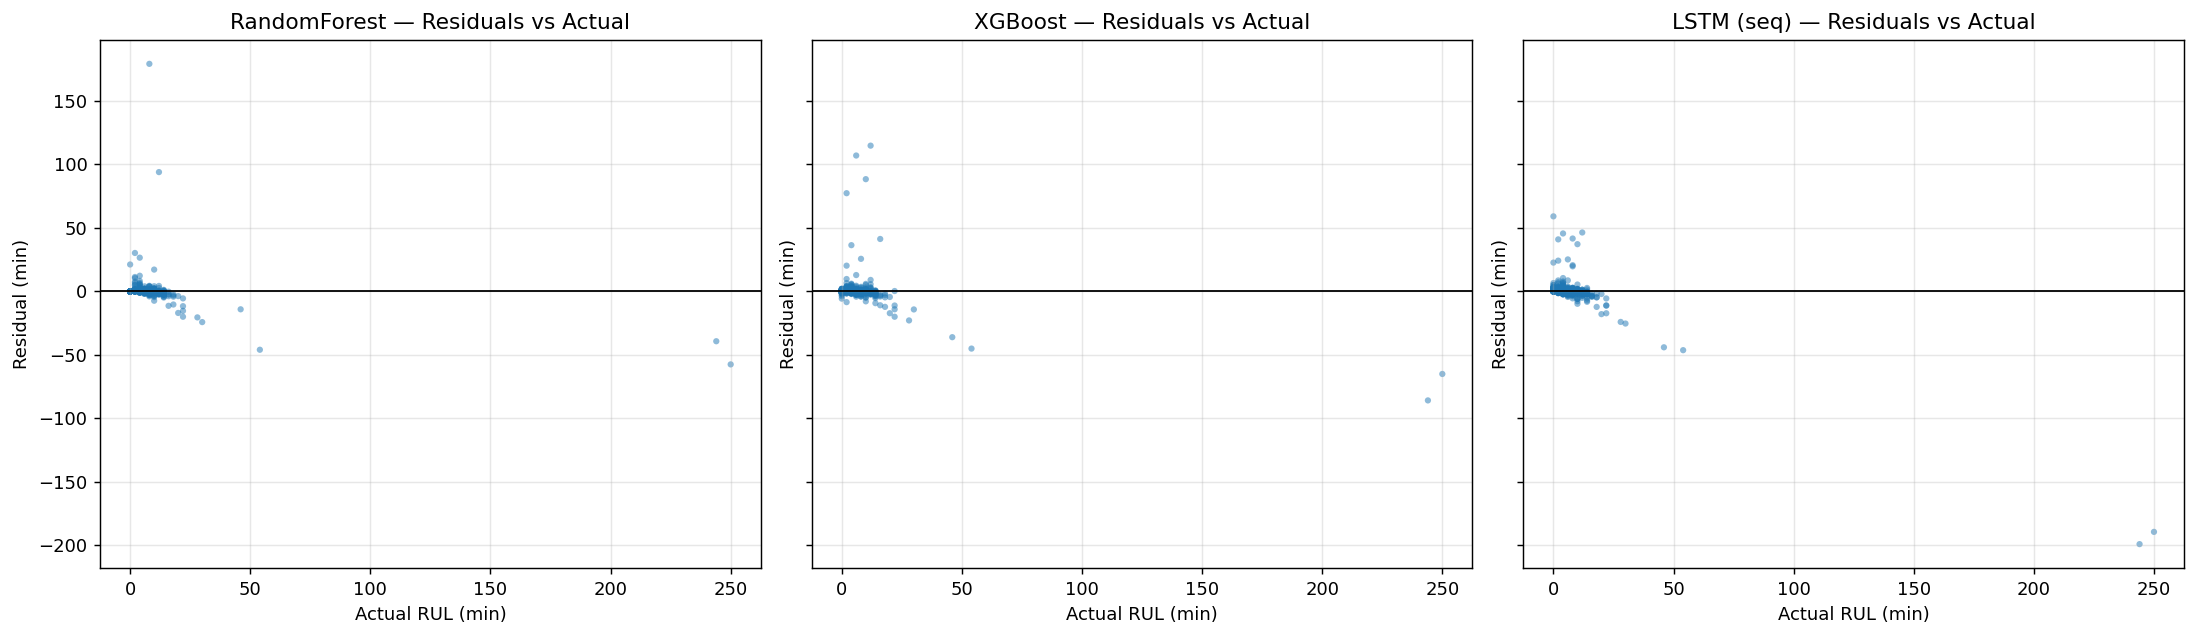

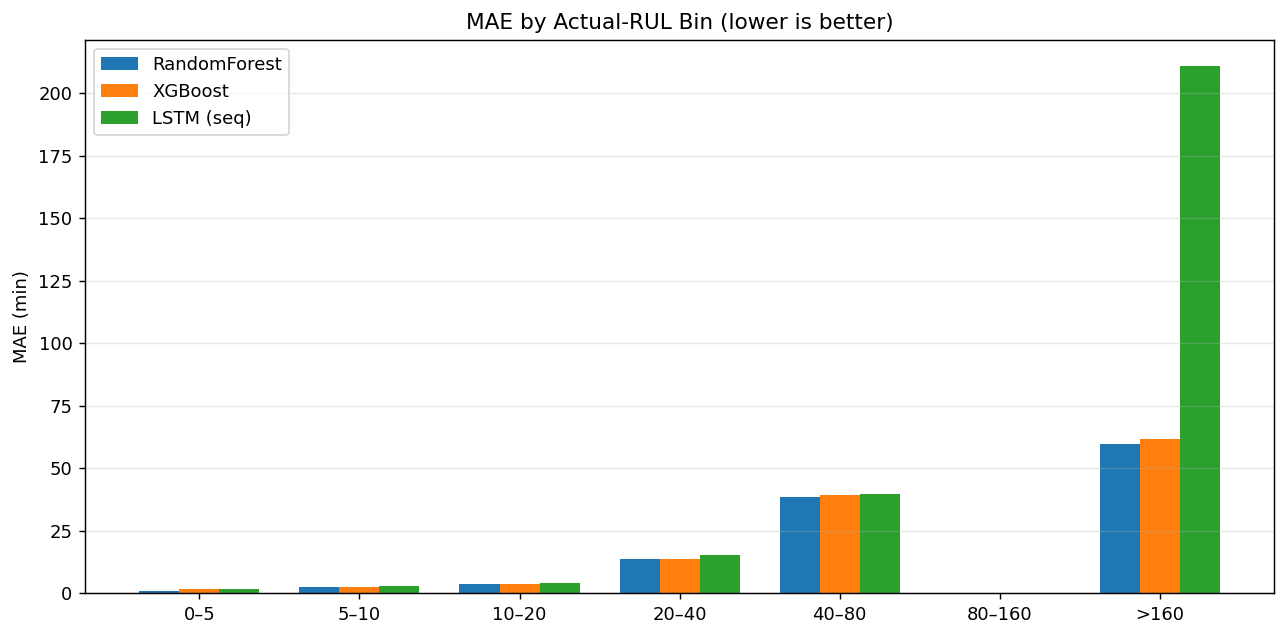

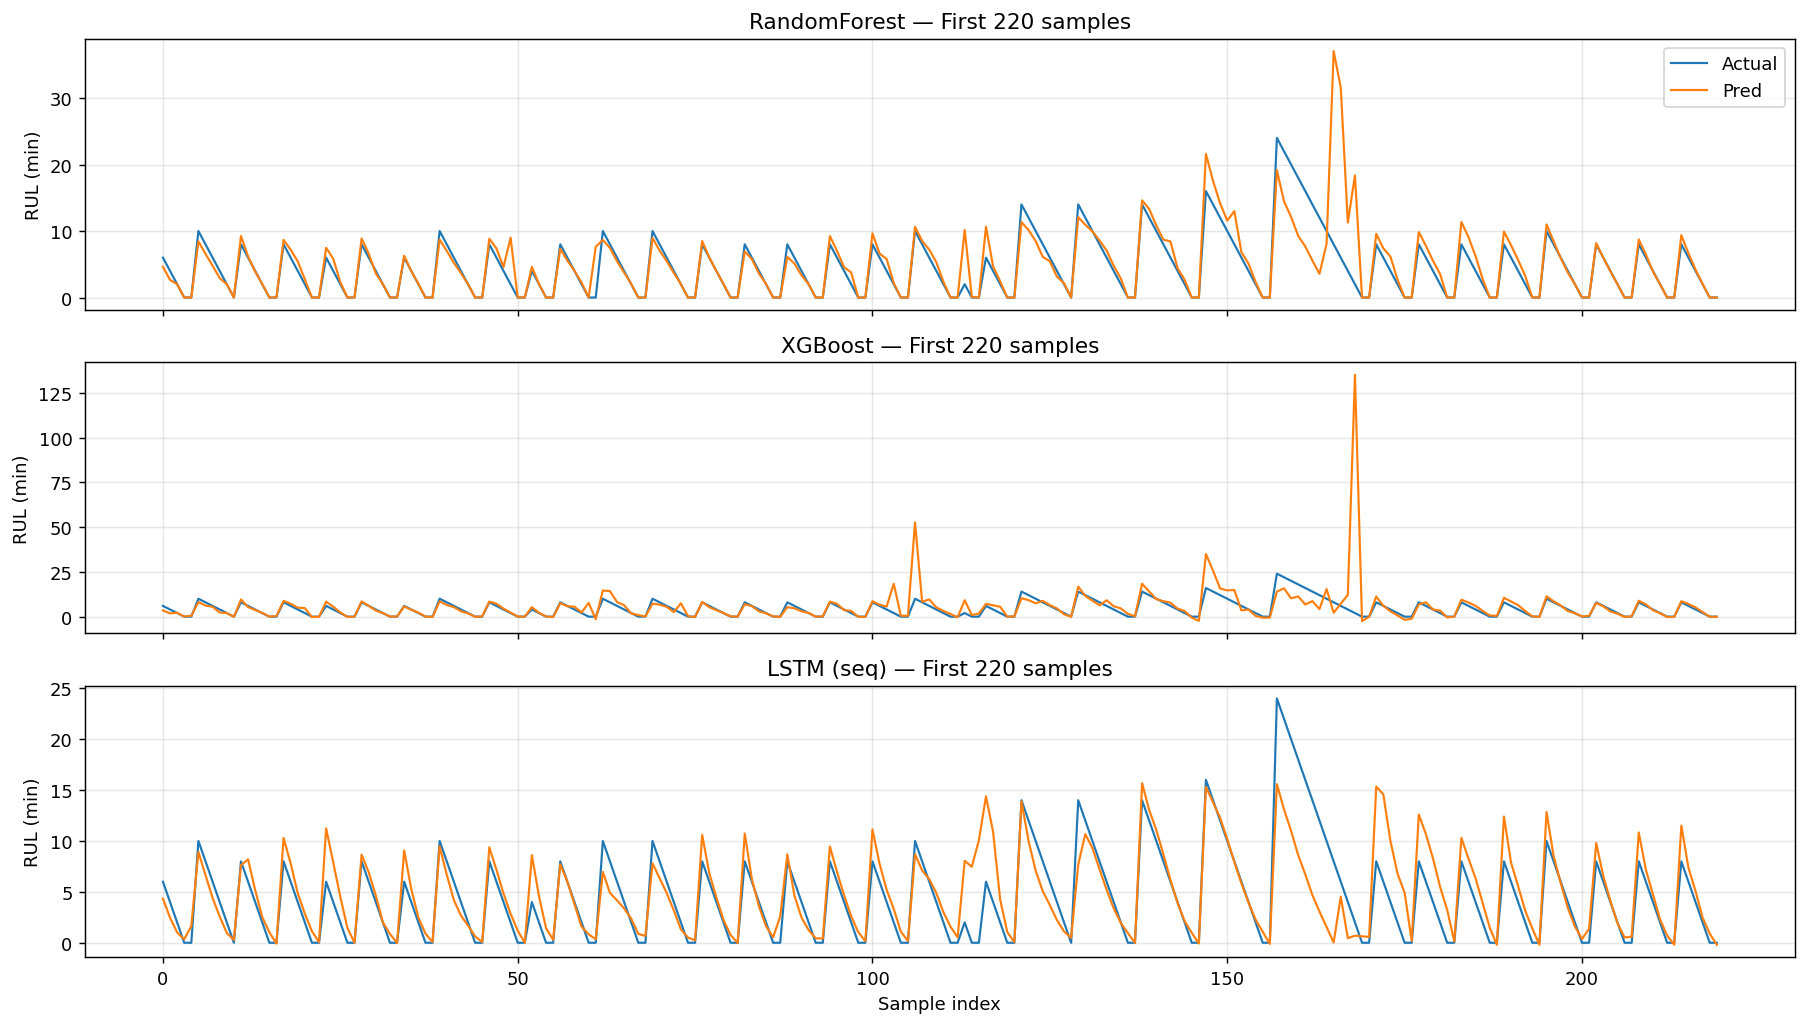

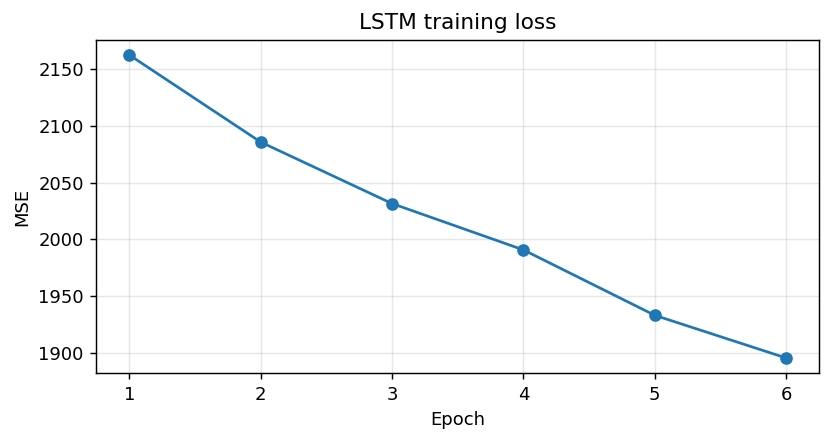

In [0]:
# ============================
# Full comparison: RF vs XGB vs LSTM
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

plt.rcParams["figure.dpi"] = 130

# -------------------------------------------------------
# 0) Spark → Pandas & feature matrix used by ALL models
# -------------------------------------------------------
# Keep only rows with a defined RUL (no leakage from "after last failure")
train_df = df_final.filter(df_final["RUL_minutes"].isNotNull())
pdf = train_df.toPandas()

# Cyclic time-of-day (optional but helpful and consistent across models)
if "timestamp_bin" in pdf.columns:
    tod_min = pdf["timestamp_bin"].dt.hour * 60 + pdf["timestamp_bin"].dt.minute
    pdf["tod_sin"] = np.sin(2*np.pi * tod_min / 1440.0)
    pdf["tod_cos"] = np.cos(2*np.pi * tod_min / 1440.0)

# Drop non-features / leakage columns
drop_cols = [
    "timestamp_bin", "failure", "next_failure_time",
    "last_failure_time", "minutes_since_last_failure", "RUL_minutes"
]
y = pdf["RUL_minutes"].astype(float).to_numpy()

# numeric features only, exclude leakage
feat_cols = [c for c in pdf.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(pdf[c])]
X = pdf[feat_cols].replace([np.inf, -np.inf], np.nan).astype(float)

# time-ordered split (same for all models)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)

# Impute with TRAIN medians (no leakage)
train_meds = X_train.median(numeric_only=True)
X_train = X_train.fillna(train_meds)
X_test  = X_test.fillna(train_meds)

print(f"Features: {len(feat_cols)} | Train {X_train.shape} | Test {X_test.shape}")

# -------------------------------------------------------
# 1) Classical models (RF, XGB)
# -------------------------------------------------------
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror", n_estimators=600, learning_rate=0.05,
    max_depth=6, subsample=0.8, colsample_bytree=0.8,
    tree_method="hist", n_jobs=-1, random_state=42
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# -------------------------------------------------------
# 2) LSTM using the *same* features & same split
# -------------------------------------------------------
# Build full matrix in the same order so we can slice a test set that aligns in time
X_full = pd.concat([X_train, X_test], axis=0)[feat_cols].to_numpy(dtype=np.float32)
y_full = np.concatenate([y_train, y_test])
cut = len(y_train)   # index where test begins

SEQ_LEN = 30  # 30 two-minute bins ~ 1 hour, adjust if you like

# Sliding-window sequences (target at the window's end)
Xs, ys, tgt_idx = [], [], []
for i in range(len(X_full) - SEQ_LEN):
    Xs.append(X_full[i:i+SEQ_LEN])
    ys.append(y_full[i+SEQ_LEN])
    tgt_idx.append(i + SEQ_LEN)
Xs, ys, tgt_idx = np.asarray(Xs, np.float32), np.asarray(ys, np.float32), np.asarray(tgt_idx)

# Train/test split for sequences aligned by the same temporal cut
mask_test = tgt_idx >= cut
Xseq_tr, Yseq_tr = Xs[~mask_test], ys[~mask_test]
Xseq_te, Yseq_te = Xs[mask_test],  ys[mask_test]

# Normalize with TRAIN sequences only
mu  = Xseq_tr.mean(axis=(0,1), keepdims=True)
std = Xseq_tr.std(axis=(0,1), keepdims=True); std[std == 0] = 1e-6
Xseq_tr = (Xseq_tr - mu) / std
Xseq_te = (Xseq_te - mu) / std

# LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden=64, layers=2):
        super().__init__()
        self.lstm = nn.LSTM(n_features, hidden, num_layers=layers, batch_first=True, dropout=0.2)
        self.fc   = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze(-1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMRegressor(n_features=Xseq_tr.shape[2]).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=1e-3)
lossf = nn.MSELoss()

train_ds = TensorDataset(torch.tensor(Xseq_tr), torch.tensor(Yseq_tr))
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True)

epoch_losses = []
model.train()
for ep in range(6):
    total = 0.0
    for xb, yb in train_ld:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        pred = model(xb)
        loss = lossf(pred, yb)
        loss.backward(); opt.step()
        total += loss.item()
    epoch_losses.append(total/len(train_ld))
    print(f"Epoch {ep+1}: loss={epoch_losses[-1]:.4f}")

model.eval()
with torch.no_grad():
    y_pred_lstm = model(torch.tensor(Xseq_te, device=device)).cpu().numpy()

# -------------------------------------------------------
# 3) Metrics & comparison table
# -------------------------------------------------------
def r2_score_(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2) + 1e-12
    return 1.0 - ss_res/ss_tot

def smape(y_true, y_pred, eps=1e-6):
    return 100.0*np.mean(np.abs(y_pred - y_true) / (np.abs(y_true)+np.abs(y_pred)+eps))

def within_tol(y_true, y_pred, tol):
    return 100.0*np.mean(np.abs(y_pred - y_true) <= tol)

def row(name, yt, yp):
    return {
        "Model": name,
        "MAE (min)": mean_absolute_error(yt, yp),
        "RMSE (min)": mean_squared_error(yt, yp, squared=False),
        "R²": r2_score_(yt, yp),
        "Bias (min)": float(np.mean(yp - yt)),
        "sMAPE (%)": smape(yt, yp),
        "≤5 min %": within_tol(yt, yp, 5),
        "≤10 min %": within_tol(yt, yp, 10),
        "N": len(yt)
    }

# Note: LSTM test horizon equals the classical test horizon (aligned by `cut`)
results = [
    row("RandomForest", y_test, y_pred_rf),
    row("XGBoost",      y_test, y_pred_xgb),
    row("LSTM (seq)",   Yseq_te, y_pred_lstm)
]
metrics_df = pd.DataFrame(results).sort_values("RMSE (min)").reset_index(drop=True)
display(metrics_df.style.format({
    "MAE (min)": "{:.2f}", "RMSE (min)": "{:.2f}", "R²": "{:.3f}",
    "Bias (min)": "{:.2f}", "sMAPE (%)": "{:.1f}", "≤5 min %": "{:.1f}", "≤10 min %": "{:.1f}"
}))

# -------------------------------------------------------
# 4) Visual comparisons
# -------------------------------------------------------
pairs = [
    ("RandomForest", y_test, y_pred_rf),
    ("XGBoost",      y_test, y_pred_xgb),
    ("LSTM (seq)",   Yseq_te, y_pred_lstm)
]

# Common axis limits for Pred vs Actual
all_true = np.concatenate([p[1] for p in pairs])
a1, a2 = np.percentile(all_true, [1, 99])
pad = 0.05*(a2-a1+1e-6)
xy_min, xy_max = a1-pad, a2+pad

# --- Figure A: Predicted vs Actual (per model)
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
for ax, (name, yt, yp) in zip(axes, pairs):
    n = len(yt); idx = np.linspace(0, n-1, min(n, 500)).astype(int)
    ax.scatter(yt[idx], yp[idx], s=14, alpha=0.5, edgecolors="none")
    ax.plot([xy_min, xy_max], [xy_min, xy_max], "k--", lw=1)
    ax.set_title(f"{name} — Pred vs Actual")
    ax.set_xlabel("Actual RUL (min)"); ax.set_ylabel("Predicted RUL (min)")
    ax.set_xlim(xy_min, xy_max); ax.set_ylim(xy_min, xy_max)
    ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# --- Figure B: Error hist overlay + bias lines
plt.figure(figsize=(9,5))
bins = 70
all_err = []
for name, yt, yp in pairs:
    err = yp - yt
    all_err.append(err)
    plt.hist(err, bins=bins, alpha=0.45, label=name)
plt.axvline(0, color="k", lw=1)
for (name, yt, yp), err in zip(pairs, all_err):
    mu = float(np.mean(err))
    plt.axvline(mu, ls="--", lw=1, label=f"{name} bias={mu:.1f}")
plt.title("Prediction Error (Pred - Actual)"); plt.xlabel("Error (min)"); plt.ylabel("Count")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# --- Figure C: Accuracy vs tolerance curve
plt.figure(figsize=(8,5))
tols = np.arange(0, 61, 2)
for name, yt, yp in pairs:
    acc = [within_tol(yt, yp, t) for t in tols]
    plt.plot(tols, acc, label=name)
plt.xlabel("Tolerance (± minutes)"); plt.ylabel("Within tolerance (%)")
plt.title("Accuracy vs Tolerance (higher is better)")
plt.grid(True, alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# --- Figure D: Residuals vs Actual (bias pattern check)
fig, axes = plt.subplots(1, 3, figsize=(17,5), sharey=True)
for ax, (name, yt, yp) in zip(axes, pairs):
    res = yp - yt
    n = len(yt); idx = np.linspace(0, n-1, min(n, 500)).astype(int)
    ax.scatter(yt[idx], res[idx], s=12, alpha=0.5, edgecolors="none")
    ax.axhline(0, color="k", lw=1)
    ax.set_title(f"{name} — Residuals vs Actual")
    ax.set_xlabel("Actual RUL (min)"); ax.set_ylabel("Residual (min)")
    ax.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# --- Figure E: MAE by actual-RUL bins
def binned_mae(yt, yp, edges):
    idx = np.digitize(yt, edges) - 1
    out = []
    for b in range(len(edges)-1):
        m = (idx == b)
        out.append(np.mean(np.abs(yp[m]-yt[m])) if np.any(m) else np.nan)
    return np.array(out)

edges = np.array([0,5,10,20,40,80,160,1e9])
xt = ["0–5","5–10","10–20","20–40","40–80","80–160",">160"]
width = 0.25
fig, ax = plt.subplots(figsize=(10,5))
for i, (name, yt, yp) in enumerate(pairs):
    mae_bins = binned_mae(yt, yp, edges)
    ax.bar(np.arange(len(xt))+i*width, mae_bins, width=width, label=name)
ax.set_xticks(np.arange(len(xt))+width); ax.set_xticklabels(xt)
ax.set_ylabel("MAE (min)"); ax.set_title("MAE by Actual-RUL Bin (lower is better)")
ax.grid(True, axis="y", alpha=0.3); ax.legend(); plt.tight_layout(); plt.show()

# --- Figure F: First N time steps (per model)
N = 220
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
for ax, (name, yt, yp) in zip(axes, pairs):
    ax.plot(yt[:N], lw=1.2, label="Actual")
    ax.plot(yp[:N], lw=1.2, label="Pred")
    ax.set_title(f"{name} — First {N} samples"); ax.set_ylabel("RUL (min)")
    ax.grid(True, alpha=0.3)
axes[-1].set_xlabel("Sample index"); axes[0].legend(loc="upper right")
plt.tight_layout(); plt.show()

# --- (Optional) LSTM epoch losses
plt.figure(figsize=(6.5,3.5))
plt.plot(range(1,len(epoch_losses)+1), epoch_losses, marker="o")
plt.title("LSTM training loss"); plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()



=== Training LSTM hidden=32 layers=2 ===


/local_disk0/.ephemeral_nfs/envs/pythonEnv-afbe02b8-a918-493f-b96a-227840cca19c/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 01 | train 11643.7312  val 1937.9777
Epoch 02 | train 11319.0848  val 1876.3478
Epoch 03 | train 11143.1990  val 1750.3569
Epoch 04 | train 11041.1915  val 1689.1910
Epoch 05 | train 10885.8402  val 1679.2448
Epoch 06 | train 10778.6130  val 1589.8683
Epoch 07 | train 10630.2080  val 1520.7993
Epoch 08 | train 10484.3265  val 1649.3394
Epoch 09 | train 10386.7005  val 1446.9243
Epoch 10 | train 10271.9301  val 1630.1327
Epoch 11 | train 10129.8923  val 1545.4294
Epoch 12 | train 10051.0236  val 1266.8064
Epoch 13 | train 9934.8591  val 1582.8656
Epoch 14 | train 9817.6372  val 1517.1239
Epoch 15 | train 9630.9364  val 1425.3530
Epoch 16 | train 9565.1316  val 1366.0707
Epoch 17 | train 9414.2389  val 1705.8556
Epoch 18 | train 9389.0408  val 1000.6587
Epoch 19 | train 9167.3399  val 1638.3509
Epoch 20 | train 9109.8166  val 1737.7966
Epoch 21 | train 9007.6795  val 1294.6469
Epoch 22 | train 9003.9181  val 1650.1960
Epoch 23 | train 8773.1734  val 985.8595
Epoch 24 | train 8683.4

/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-afbe02b8-a918-493f-b96a-227840cca19c/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Training LSTM hidden=64 layers=2 ===
Epoch 01 | train 11451.1661  val 1872.6379
Epoch 02 | train 11100.5417  val 1785.3029
Epoch 03 | train 10857.0229  val 1828.3747
Epoch 04 | train 10636.3271  val 1816.6455
Epoch 05 | train 10426.1727  val 1494.3665
Epoch 06 | train 10200.9495  val 1337.5226
Epoch 07 | train 9987.7804  val 1413.1235
Epoch 08 | train 9797.5614  val 1285.9240
Epoch 09 | train 9656.5250  val 1538.1624
Epoch 10 | train 9402.5225  val 1536.9723
Epoch 11 | train 9206.9993  val 1392.5750
Epoch 12 | train 9028.2000  val 1252.3121
Epoch 13 | train 8820.0115  val 1715.9580
Epoch 14 | train 8679.1270  val 1692.6767
Epoch 15 | train 8410.8744  val 1442.6002
Epoch 16 | train 8225.1078  val 1564.1301
Epoch 17 | train 8090.3306  val 1224.8986
Epoch 18 | train 7900.8576  val 1272.1580
Epoch 19 | train 7724.7735  val 1267.9775
Epoch 20 | train 7713.2210  val 1562.9553
Epoch 21 | train 7595.3888  val 1331.2825
Epoch 22 | train 7408.8160  val 1566.6692
Epoch 23 | train 7269.1293  

/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-afbe02b8-a918-493f-b96a-227840cca19c/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Training LSTM hidden=128 layers=2 ===
Epoch 01 | train 11273.2447  val 1976.5052
Epoch 02 | train 10784.7629  val 1512.8640
Epoch 03 | train 10439.0726  val 1816.0136
Epoch 04 | train 10191.4522  val 1389.7028
Epoch 05 | train 9972.5070  val 1229.1064
Epoch 06 | train 9709.1163  val 1647.9129
Epoch 07 | train 9581.5103  val 1644.4720
Epoch 08 | train 9059.3303  val 1143.0224
Epoch 09 | train 8839.3890  val 1458.6701
Epoch 10 | train 8641.1258  val 1909.9015
Epoch 11 | train 8349.5356  val 551.5786
Epoch 12 | train 8075.4220  val 1285.0662
Epoch 13 | train 7967.0349  val 1468.0159
Epoch 14 | train 7614.4644  val 842.6304
Epoch 15 | train 7289.3203  val 1191.0004
Epoch 16 | train 7158.2950  val 1291.8301
Epoch 17 | train 6985.3913  val 1674.2375
Early stopping at epoch 17 (best val 551.5786)


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-afbe02b8-a918-493f-b96a-227840cca19c/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Training GRU hidden=32 layers=2 ===
Epoch 01 | train 11603.4401  val 1936.0375
Epoch 02 | train 11296.4833  val 1827.2915
Epoch 03 | train 11105.7171  val 1781.8360
Epoch 04 | train 10978.3195  val 1793.9004
Epoch 05 | train 10860.7376  val 1738.2297
Epoch 06 | train 10749.6037  val 1628.7798
Epoch 07 | train 10655.9163  val 1523.9887
Epoch 08 | train 10574.4323  val 1755.7605
Epoch 09 | train 10453.1241  val 1425.5154
Epoch 10 | train 10389.6907  val 1787.2633
Epoch 11 | train 10266.1558  val 1439.5670
Epoch 12 | train 10165.6207  val 1767.1545
Epoch 13 | train 10016.4594  val 1655.1519
Epoch 14 | train 9911.1342  val 1667.4229
Epoch 15 | train 9848.0692  val 1337.0396
Epoch 16 | train 9720.5035  val 1397.6553
Epoch 17 | train 9611.3973  val 1545.5724
Epoch 18 | train 9490.5430  val 1102.8568
Epoch 19 | train 9344.2215  val 1071.1832
Epoch 20 | train 9226.8470  val 1325.9017
Epoch 21 | train 9095.5642  val 1142.9342
Epoch 22 | train 8991.4173  val 990.1327
Epoch 23 | train 8906.7

/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-afbe02b8-a918-493f-b96a-227840cca19c/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Training GRU hidden=64 layers=2 ===
Epoch 01 | train 11459.3800  val 1842.1363
Epoch 02 | train 11057.9865  val 1688.0908
Epoch 03 | train 10788.6806  val 1666.7030
Epoch 04 | train 10585.1331  val 1470.7165
Epoch 05 | train 10444.7909  val 1494.0929
Epoch 06 | train 10247.7821  val 1442.8844
Epoch 07 | train 10056.4090  val 1368.5457
Epoch 08 | train 9885.0942  val 1544.4095
Epoch 09 | train 9698.4973  val 1638.3477
Epoch 10 | train 9480.3913  val 1300.3592
Epoch 11 | train 9291.8063  val 1141.9198
Epoch 12 | train 9041.4044  val 1185.7783
Epoch 13 | train 8876.6748  val 1687.6371
Epoch 14 | train 8598.4003  val 1577.0129
Epoch 15 | train 8592.6255  val 1371.6428
Epoch 16 | train 8259.4739  val 1768.0029
Epoch 17 | train 8055.7888  val 1682.7095
Early stopping at epoch 17 (best val 1141.9198)


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/local_disk0/.ephemeral_nfs/envs/pythonEnv-afbe02b8-a918-493f-b96a-227840cca19c/lib/python3.12/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



=== Training GRU hidden=128 layers=2 ===
Epoch 01 | train 11267.6314  val 1720.9764
Epoch 02 | train 10731.7635  val 1592.6064
Epoch 03 | train 10396.4755  val 1605.9811
Epoch 04 | train 10086.6200  val 1511.3749
Epoch 05 | train 9900.4466  val 1095.6332
Epoch 06 | train 9635.6971  val 1496.7801
Epoch 07 | train 9306.8028  val 997.5212
Epoch 08 | train 9005.9094  val 774.1417
Epoch 09 | train 8802.6229  val 1491.1766
Epoch 10 | train 8573.2281  val 1003.3465
Epoch 11 | train 8131.1022  val 507.0319
Epoch 12 | train 8029.1567  val 1103.1165
Epoch 13 | train 7566.4607  val 599.7383
Epoch 14 | train 7313.5144  val 1134.9082
Epoch 15 | train 7154.0436  val 538.6052
Epoch 16 | train 6900.1681  val 887.4848
Epoch 17 | train 6562.7587  val 1410.8808
Early stopping at epoch 17 (best val 507.0319)


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


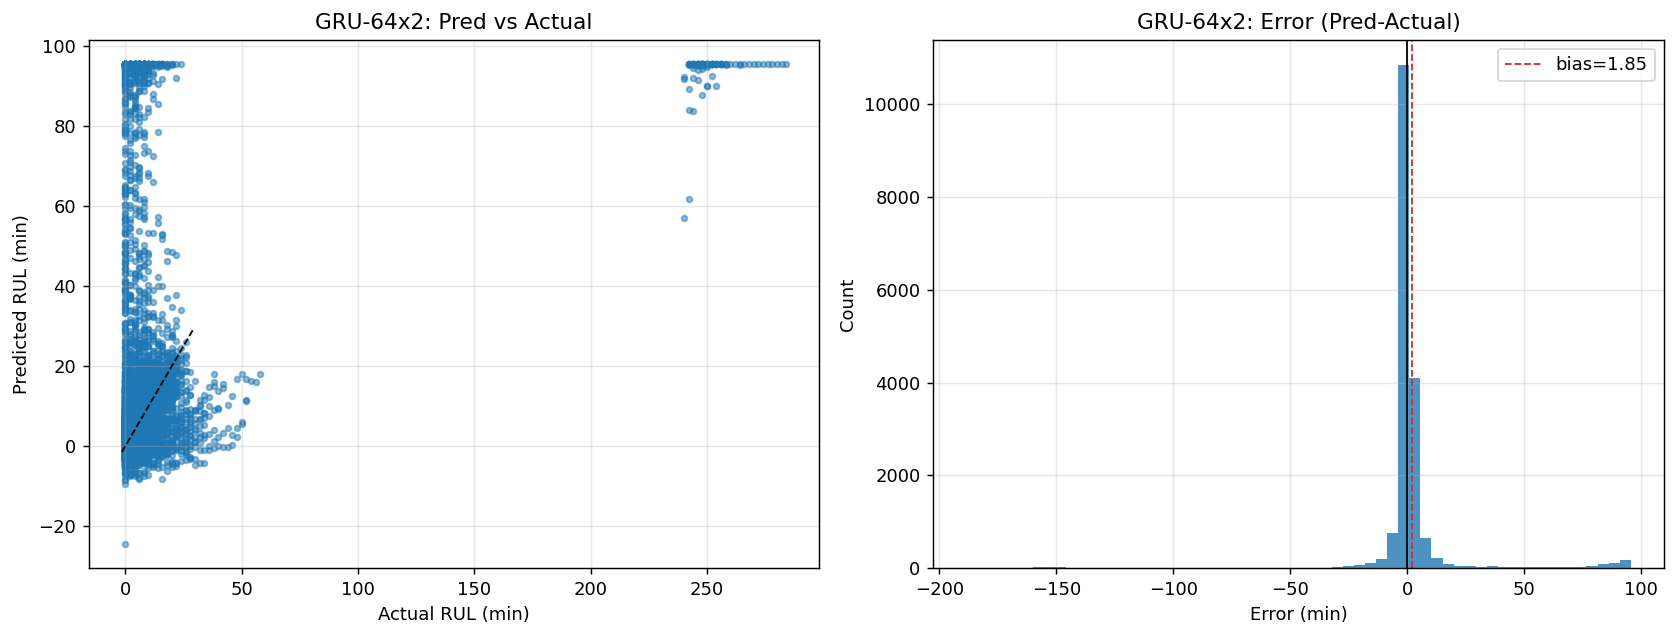

In [0]:
# ============================================
# Deep sequence models: LSTM vs GRU bake-off
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

plt.rcParams["figure.dpi"] = 130

# -----------------------------
# 0) Spark -> Pandas & features
# -----------------------------
# Use the same filtered dataset (no leakage after last failure)
train_df = df_final.filter(df_final["RUL_minutes"].isNotNull())
pdf = train_df.toPandas()

# Add cyclic time-of-day
if "timestamp_bin" in pdf.columns:
    tod_min = pdf["timestamp_bin"].dt.hour * 60 + pdf["timestamp_bin"].dt.minute
    pdf["tod_sin"] = np.sin(2*np.pi * tod_min / 1440.0)
    pdf["tod_cos"] = np.cos(2*np.pi * tod_min / 1440.0)

drop_cols = [
    "timestamp_bin", "failure", "next_failure_time",
    "last_failure_time", "minutes_since_last_failure", "RUL_minutes"
]
y = pdf["RUL_minutes"].astype(float).to_numpy()

feat_cols = [c for c in pdf.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(pdf[c])]
X = pdf[feat_cols].replace([np.inf, -np.inf], np.nan).astype(float)

# time-ordered split identical to classic models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=False)
train_meds = X_train.median(numeric_only=True)
X_train = X_train.fillna(train_meds)
X_test  = X_test.fillna(train_meds)

# -----------------------------
# 1) Build sequences (same cut)
# -----------------------------
X_full = pd.concat([X_train, X_test], axis=0)[feat_cols].to_numpy(dtype=np.float32)
y_full = np.concatenate([y_train, y_test]).astype(np.float32)
cut = len(y_train)  # first index of the classical TEST set

SEQ_LEN = 30  # ~1 hour if your bins are 2 min; change if needed

Xs, ys, tgt_idx = [], [], []
for i in range(len(X_full) - SEQ_LEN):
    Xs.append(X_full[i:i+SEQ_LEN])
    ys.append(y_full[i+SEQ_LEN])
    tgt_idx.append(i + SEQ_LEN)
Xs = np.asarray(Xs, dtype=np.float32)
ys = np.asarray(ys, dtype=np.float32)
tgt_idx = np.asarray(tgt_idx)

# Split sequences so that the target belongs to train/test by the same time cut
mask_test = tgt_idx >= cut
Xseq_tr, Yseq_tr = Xs[~mask_test], ys[~mask_test]
Xseq_te, Yseq_te = Xs[mask_test],  ys[mask_test]

# Normalize using TRAIN only
mu  = Xseq_tr.mean(axis=(0,1), keepdims=True)
std = Xseq_tr.std(axis=(0,1), keepdims=True); std[std == 0] = 1e-6
Xseq_tr = (Xseq_tr - mu) / std
Xseq_te = (Xseq_te - mu) / std

# Create a small validation tail from training (time-ordered, no shuffle)
val_frac = 0.1
n_tr = len(Xseq_tr)
n_val = int(n_tr * val_frac)
Xseq_val, Yseq_val = Xseq_tr[-n_val:], Yseq_tr[-n_val:]
Xseq_tr,  Yseq_tr  = Xseq_tr[:-n_val], Yseq_tr[:-n_val]

# ---------------------------------------------------
# 2) Bin-weighted loss to balance long vs short RUL
# ---------------------------------------------------
# Define bins and compute inverse-frequency weights on TRAIN targets only
bin_edges = np.array([0, 5, 10, 20, 40, 80, 160, 1e9], dtype=np.float32)
tr_bins = np.digitize(Yseq_tr, bin_edges) - 1
counts = np.bincount(np.clip(tr_bins, 0, len(bin_edges)-2), minlength=len(bin_edges)-1)
# class-balanced weighting: total/(#bins * count)
class_w = (len(Yseq_tr) / ((len(bin_edges)-1) * np.maximum(counts, 1))).astype(np.float32)
# gentle cap to avoid extreme weights
class_w = np.clip(class_w, 0.3, 5.0)

def make_sample_weights(y):
    b = np.digitize(y, bin_edges) - 1
    b = np.clip(b, 0, len(class_w)-1)
    return class_w[b]

w_tr = make_sample_weights(Yseq_tr)
w_val = make_sample_weights(Yseq_val)
w_te  = make_sample_weights(Yseq_te)  # not used in loss, just for analysis if needed

# ----------------------
# 3) PyTorch data pipes
# ----------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

def to_loader(X, y, w, batch=256, shuffle=False):
    X_t = torch.tensor(X, dtype=torch.float32)
    y_t = torch.tensor(y, dtype=torch.float32)
    w_t = torch.tensor(w, dtype=torch.float32)
    ds = TensorDataset(X_t, y_t, w_t)
    return DataLoader(ds, batch_size=batch, shuffle=shuffle, pin_memory=True)

train_ld = to_loader(Xseq_tr,  Yseq_tr,  w_tr, shuffle=True)
val_ld   = to_loader(Xseq_val, Yseq_val, w_val, shuffle=False)
test_ld  = to_loader(Xseq_te,  Yseq_te,  w_te, shuffle=False)

n_features = Xseq_tr.shape[2]

# ----------------------
# 4) Model definitions
# ----------------------
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden=64, layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features, hidden_size=hidden,
            num_layers=layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze(1)

class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden=64, layers=2, dropout=0.2):
        super().__init__()
        self.gru = nn.GRU(
            input_size=n_features, hidden_size=hidden,
            num_layers=layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :]).squeeze(1)

# weighted MSE
def weighted_mse(pred, target, weight):
    return torch.mean((pred - target) ** 2 * weight)

# ----------------------
# 5) Train/eval routine
# ----------------------
def r2_score_np(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - y_true.mean())**2) + 1e-12
    return 1.0 - ss_res/ss_tot

def within_tol(y_true, y_pred, tol):
    return 100.0 * np.mean(np.abs(y_pred - y_true) <= tol)

@torch.no_grad()
def predict_model(model, loader):
    model.eval()
    preds, trues = [], []
    for xb, yb, _ in loader:
        xb = xb.to(device)
        yhat = model(xb).cpu().numpy()
        preds.append(yhat)
        trues.append(yb.numpy())
    return np.concatenate(trues), np.concatenate(preds)

def train_one(model, epochs=50, lr=1e-3, patience=6, clip=1.0):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_state, best_val = None, float("inf")
    train_hist, val_hist = [], []

    for ep in range(1, epochs+1):
        # ---- train
        model.train()
        running = 0.0
        for xb, yb, wb in train_ld:
            xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = weighted_mse(pred, yb, wb)
            loss.backward()
            if clip is not None:
                nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt.step()
            running += loss.item()
        train_loss = running / max(1, len(train_ld))
        train_hist.append(train_loss)

        # ---- validate
        model.eval()
        v_running = 0.0
        with torch.no_grad():
            for xb, yb, wb in val_ld:
                xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)
                pred = model(xb)
                v_running += weighted_mse(pred, yb, wb).item()
        val_loss = v_running / max(1, len(val_ld))
        val_hist.append(val_loss)

        print(f"Epoch {ep:02d} | train {train_loss:.4f}  val {val_loss:.4f}")

        # early stopping
        if val_loss + 1e-6 < best_val:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {ep} (best val {best_val:.4f})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, train_hist, val_hist

def evaluate(name, model):
    yt, yp = predict_model(model, test_ld)
    out = {
        "Model": name,
        "MAE (min)": mean_absolute_error(yt, yp),
        "RMSE (min)": mean_squared_error(yt, yp, squared=False),
        "R²": r2_score_np(yt, yp),
        "≤5 min %": within_tol(yt, yp, 5),
        "≤10 min %": within_tol(yt, yp, 10),
        "Bias (min)": float(np.mean(yp - yt)),
        "N": len(yt)
    }
    return out, yt, yp

# ----------------------
# 6) Run small grid
# ----------------------
configs = [
    ("LSTM", 32, 2), ("LSTM", 64, 2), ("LSTM", 128, 2),
    ("GRU",  32, 2), ("GRU",  64, 2), ("GRU",  128, 2),
]

results = []
pred_cache = {}   # name -> (yt, yp)
for kind, hidden, layers in configs:
    print(f"\n=== Training {kind} hidden={hidden} layers={layers} ===")
    if kind.lower() == "lstm":
        net = LSTMRegressor(n_features, hidden=hidden, layers=layers, dropout=0.2)
    else:
        net = GRURegressor(n_features, hidden=hidden, layers=layers, dropout=0.2)

    net, tr_hist, va_hist = train_one(net, epochs=50, lr=1e-3, patience=6, clip=1.0)
    name = f"{kind}-{hidden}x{layers}"
    res, yt, yp = evaluate(name, net)
    results.append(res)
    pred_cache[name] = (yt, yp)

# ----------------------
# 7) Show results
# ----------------------
metrics_df = pd.DataFrame(results).sort_values("RMSE (min)").reset_index(drop=True)
display(metrics_df.style.format({
    "MAE (min)": "{:.2f}", "RMSE (min)": "{:.2f}", "R²": "{:.3f}",
    "≤5 min %": "{:.1f}", "≤10 min %": "{:.1f}", "Bias (min)": "{:.2f}"
}))

best_name = metrics_df.iloc[0]["Model"]
yt_best, yp_best = pred_cache[best_name]

# Quick visual: best deep model Pred vs Actual + error histogram
fig, ax = plt.subplots(1, 2, figsize=(13,5))
# Pred vs Actual
mn, mx = float(np.percentile(yt_best, 1)), float(np.percentile(yt_best, 99))
pad = 0.05*(mx - mn + 1e-6)
ax[0].scatter(yt_best, yp_best, s=10, alpha=0.5)
ax[0].plot([mn-pad, mx+pad], [mn-pad, mx+pad], "k--", lw=1)
ax[0].set_title(f"{best_name}: Pred vs Actual")
ax[0].set_xlabel("Actual RUL (min)"); ax[0].set_ylabel("Predicted RUL (min)")
ax[0].grid(True, alpha=0.3)
# Error histogram
err = yp_best - yt_best
ax[1].hist(err, bins=60, alpha=0.8)
ax[1].axvline(0, color="k", lw=1)
ax[1].axvline(err.mean(), color="tab:red", ls="--", lw=1, label=f"bias={err.mean():.2f}")
ax[1].set_title(f"{best_name}: Error (Pred-Actual)")
ax[1].set_xlabel("Error (min)"); ax[1].set_ylabel("Count"); ax[1].legend()
ax[1].grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


ℹ️ No LSTM found in S3 — skipping.


/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/databricks/python/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


               Model       MAE       RMSE  ...     ≤5 min    ≤10 min        R²
0  RandomForest (S3)  2.478588  12.940248  ...  93.428222  96.424997  0.511292
1       XGBoost (S3)  3.038589  12.307284  ...  90.581563  95.396419  0.557933

[2 rows x 8 columns]


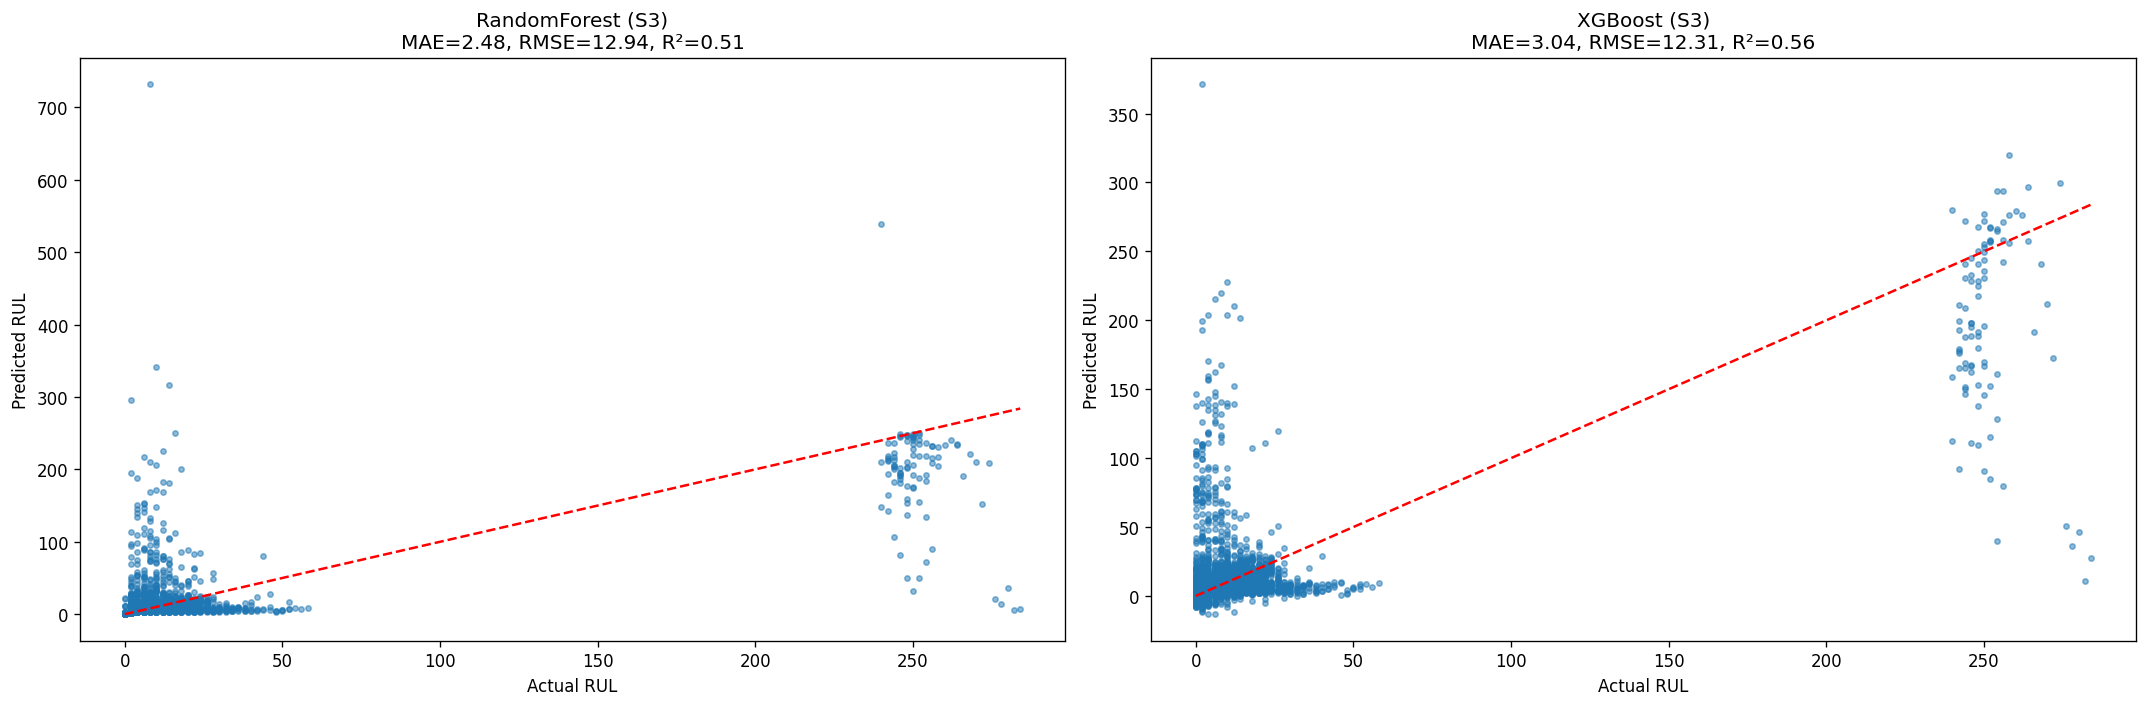

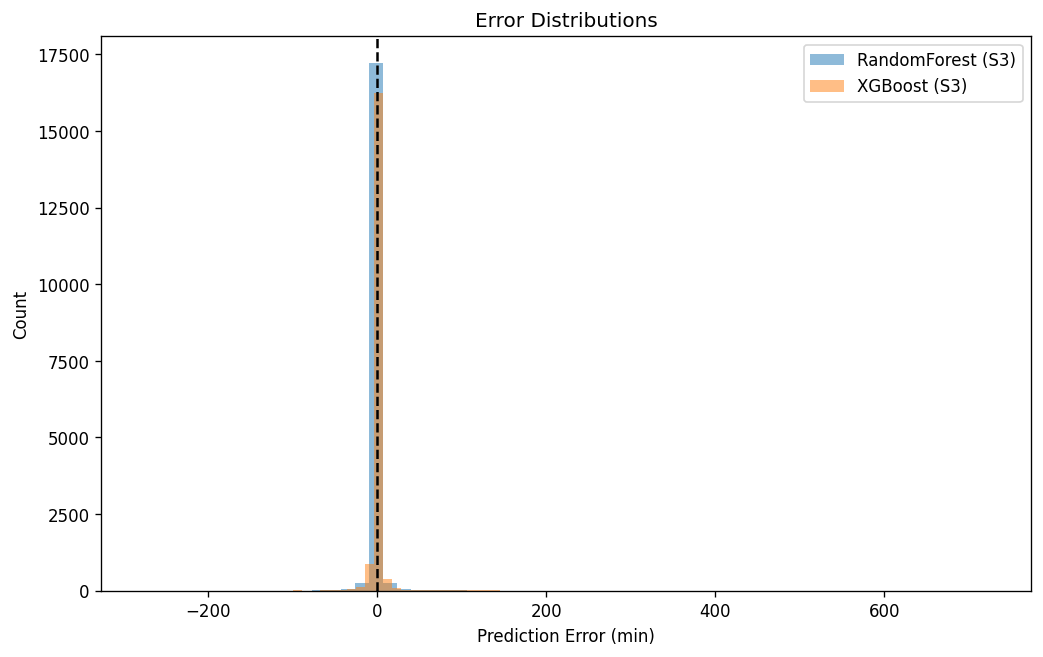

In [0]:
import joblib
import boto3
import os

# --- Download from S3 ---
bucket = "hqpsusu-ml-data-bucket"
prefix = "final_project/models/"

s3 = boto3.client("s3")

local_rf  = "/tmp/rf_model.pkl"
local_xgb = "/tmp/xgb_model.pkl"

s3.download_file(bucket, prefix + "rf_model.pkl", local_rf)
s3.download_file(bucket, prefix + "xgb_model.pkl", local_xgb)

# --- Load models ---
rf_loaded  = joblib.load(local_rf)
xgb_loaded = joblib.load(local_xgb)


# Optional: LSTM
try:
    import torch
    lstm_loaded = mlflow.pytorch.load_model(lstm_uri)
    has_lstm = True
except Exception:
    print("ℹ️ No LSTM found in S3 — skipping.")
    has_lstm = False

# =========================================================
# 3) Evaluation helper
# =========================================================
def eval_model(name, y_true, y_pred):
    eps = 1e-6
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    yt, yp = np.asarray(y_true)[mask], np.asarray(y_pred)[mask]
    errors = yp - yt
    abs_err = np.abs(errors)
    
    return {
        "Model": name,
        "MAE": mean_absolute_error(yt, yp),
        "RMSE": mean_squared_error(yt, yp, squared=False),
        "Bias": np.mean(errors),
        "sMAPE (%)": 100.0 * np.mean(2.0 * abs_err / (np.abs(yt) + np.abs(yp) + eps)),
        "≤5 min": 100.0 * np.mean(abs_err <= 5),
        "≤10 min": 100.0 * np.mean(abs_err <= 10),
        "R²": r2_score(yt, yp),
        "Errors": errors,
        "y_true": yt,
        "y_pred": yp
    }

# =========================================================
# 4) Run predictions
# =========================================================
results = []

# RF
y_pred_rf = rf_loaded.predict(X_test)
results.append(eval_model("RandomForest (S3)", y_test, y_pred_rf))

# XGB
y_pred_xgb = xgb_loaded.predict(X_test)
results.append(eval_model("XGBoost (S3)", y_test, y_pred_xgb))

# LSTM
if has_lstm:
    y_pred_lstm = lstm_loaded(torch.tensor(X_test.values, dtype=torch.float32)).detach().numpy().ravel()
    results.append(eval_model("LSTM (S3)", y_test, y_pred_lstm))

# =========================================================
# 5) Tabulate results
# =========================================================
df_results = pd.DataFrame(results).drop(columns=["Errors","y_true","y_pred"])
print(df_results)

# =========================================================
# 6) Visuals
# =========================================================
plt.figure(figsize=(18,6))

# (A) Predicted vs Actual
for i, res in enumerate(results, 1):
    yt, yp = res["y_true"], res["y_pred"]
    ax = plt.subplot(1, len(results), i)
    ax.scatter(yt, yp, s=10, alpha=0.5)
    mn, mx = yt.min(), yt.max()
    ax.plot([mn, mx], [mn, mx], "r--")
    ax.set_title(f"{res['Model']}\nMAE={res['MAE']:.2f}, RMSE={res['RMSE']:.2f}, R²={res['R²']:.2f}")
    ax.set_xlabel("Actual RUL")
    ax.set_ylabel("Predicted RUL")

plt.tight_layout()
plt.show()

# (B) Error distributions
plt.figure(figsize=(10,6))
for res in results:
    plt.hist(res["Errors"], bins=60, alpha=0.5, label=res["Model"])
plt.axvline(0, color="k", linestyle="--")
plt.xlabel("Prediction Error (min)")
plt.ylabel("Count")
plt.title("Error Distributions")
plt.legend()
plt.show()


In [0]:
dbutils.fs.ls("s3://hqpsusu-ml-data-bucket/final_project/models/")

[FileInfo(path='s3://hqpsusu-ml-data-bucket/final_project/models/rf_model.pkl', name='rf_model.pkl', size=6916453, modificationTime=1756336460000),
 FileInfo(path='s3://hqpsusu-ml-data-bucket/final_project/models/xgb_model.pkl', name='xgb_model.pkl', size=512300, modificationTime=1756336460000)]

In [0]:
import joblib
import boto3

# Save locally
joblib.dump(rf, "/tmp/rf_model.pkl")
joblib.dump(xgb_model, "/tmp/xgb_model.pkl")

# Upload to S3
s3 = boto3.client("s3")
bucket = "hqpsusu-ml-data-bucket"

s3.upload_file("/tmp/rf_model.pkl", bucket, "final_project/models/rf_model.pkl")
s3.upload_file("/tmp/xgb_model.pkl", bucket, "final_project/models/xgb_model.pkl")

print("✅ Models saved directly to S3.")


✅ Models saved directly to S3.
